# Multi-Task Learning Notebook 

`I hope this is the last iteration`

We are going to import three datasets:
1. Children’s fairy tales (1000-100-100, ekman categorical)
2. Emobank (9000-300-300, vad regression)
3. SemEval-2018 (~7k - 1k - 3k, multi-label)

# Install & imports

In [1]:
!pip install transformers -q
!pip install wandb -qq
!pip install -Uqq ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pdb
import wandb
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import ones_like, zeros_like

import os
import math
import copy
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# set manual seed 
np.random.seed(42)
torch.manual_seed(42)

cuda:0


## Give Access

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

wandb.login(key="013ecd9857196cedaf8d4d8d9fc8653f60335ea0")

# this is for the shared project, but it doesn't seem to work:
# API KEY: 013ecd9857196cedaf8d4d8d9fc8653f60335ea0

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Import dataset from github

In [4]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

# Read and process data

### Fairy Tale dataset & Emobank

In [5]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
print(df_children.head())
print(df_emobank.head())

Children story dataset: 1207
Emobank dataset: 9814
   Unnamed: 0                                           sentence  label
0           0  He looked around on every side and exclaimed, ...      4
1           1  Then he got up and clambered out of the cave, ...      3
2           2                    "Alas, thou canst not help me."      3
3           3  They leapt nimbly upstairs and downstairs, and...      2
4           4  Then she opened the door of the small house, a...      2
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                            

### Sem-Eval Dataset

Which already has train-val-test split

In [6]:
sem_train_filename = "SemEval2018_train.csv"
sem_val_filename = "SemEval2018_val.csv"
sem_test_filename = "SemEval2018_test.csv"

df_sem_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_train_filename))
# truncate training set!
percentage_sem = 1
df_sem_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_train_filename))[:int(percentage_sem*len(df_sem_train))]
df_sem_val = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_val_filename))
df_sem_test = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_test_filename))

print(f'Using {len(df_sem_train)} data points from SEM-EVAL Training set')

df_sem_train.head()

Using 6838 data points from SEM-EVAL Training set


,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Define Global Variables

In [7]:
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
SEM_EMOTIONS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
VAD_EMOTIONS = ['V', 'A', 'D']

# outputs heads (prediction heads)
NUM_CLASSES_EKMAN = len(EKMAN_EMOTIONS) # 5
NUM_CLASSES_SEM = len(SEM_EMOTIONS) # 11
NUM_CLASSES_VAD = len(VAD_EMOTIONS) # 3

OUT_DIMS = {
    'ekman': NUM_CLASSES_EKMAN, 'vad': NUM_CLASSES_VAD, 'sem': NUM_CLASSES_SEM
}

# label lengths (this is how many slots it takes to store the labels)
Y_DIM_EKMAN = 1
Y_DIM_VAD = NUM_CLASSES_VAD
Y_DIM_SEM = NUM_CLASSES_SEM

Y_DIMS = {
    'ekman': Y_DIM_EKMAN, 'vad': Y_DIM_VAD, 'sem': Y_DIM_SEM
}

## Load data from table to numpy array

In [8]:
# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

x_sem_train_raw = list(df_sem_train['text'])
y_sem_train_raw = df_sem_train[SEM_EMOTIONS].to_numpy()

x_sem_val_raw = list(df_sem_val['text'])
y_sem_val_raw = df_sem_val[SEM_EMOTIONS].to_numpy()

x_sem_test_raw = list(df_sem_test['text'])
y_sem_test_raw = df_sem_test[SEM_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])

print(x_sem_train_raw[0])
print(y_sem_train_raw[0])

He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]
“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
[0 1 0 0 0 0 1 0 0 0 1]


In [9]:
y_sem_train_raw.sum(axis=0)

array([2544,  978, 2602, 1242, 2477,  700, 1984,  795, 2008,  361,  357])

## Download Bert and tokenizer

In [10]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Move bert to GPU
for param in bert.parameters():
  param.requires_grad = False
bert.to(DEVICE)
print(f'moved bert to {DEVICE}')

moved bert to cuda:0


### Preprocess with Tokenizer

In [12]:
tokenized_xs = {}

encoded_input = tokenizer(x_ekman_raw, padding=True, truncation=True, return_tensors="pt")
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']
tokenized_xs['ekman'] = [X_ekman_input, X_ekman_mask]

encoded_input = tokenizer(x_vad_raw, padding=True, truncation=True, return_tensors="pt")
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']
tokenized_xs['vad'] = [X_vad_input, X_vad_mask]

encoded_input = tokenizer(x_sem_train_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_train'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_val_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_val'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_test_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_test'] = [X_input, X_mask]

### Preprocess with BERT

In [13]:
BERT_OUT_SIZE = 768
preprocessed_xs = {}

for name, X in tokenized_xs.items():
  # allocate memory
  n = X[0].shape[0]
  preprocessed_xs[name] = torch.empty(size=(n, BERT_OUT_SIZE), dtype=torch.float)

  # use minibatch to process data
  b = 100
  num_batches = math.ceil(n / b)

  print(f'Preprocessing {name}...')
  for i in tqdm(range(num_batches)):
    x_ids = X[0][i*b: (i+1)*b].to(DEVICE)
    x_masks = X[1][i*b: (i+1)*b].to(DEVICE)

    output = bert(x_ids, attention_mask=x_masks)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']
    
    preprocessed_xs[name][i*b: (i+1)*b] = pooler_output

Preprocessing ekman...


  0%|          | 0/13 [00:00<?, ?it/s]

Preprocessing vad...


  0%|          | 0/99 [00:00<?, ?it/s]

Preprocessing sem_train...


  0%|          | 0/69 [00:00<?, ?it/s]

Preprocessing sem_val...


  0%|          | 0/9 [00:00<?, ?it/s]

Preprocessing sem_test...


  0%|          | 0/33 [00:00<?, ?it/s]

In [14]:
# check for NAN
count = 0
for name, xs in preprocessed_xs.items():
  for i, x in enumerate(xs):
    if torch.any(x.isnan()) or x.abs().max() > 1:
      print('we have a problem!')
      print(f'{name}, {i}')
      print(tokenized_xs[name][0][i])
      count += 1
      # print(x)
  
print(count)

0


### Preprocess labels 
All labels need to be the same length, and we pad with 0s

In [15]:
preprocessed_ys = {}

# create placeholder tensors
ekman_zeros = torch.zeros((1, Y_DIMS['ekman']), )
vad_zeros = torch.zeros((1, Y_DIMS['vad']), )
sem_zeros = torch.zeros((1, Y_DIMS['sem']), )

# EKMAN
y = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
n = y.shape[0]
y = torch.concatenate((y, vad_zeros.repeat(n, 1), sem_zeros.repeat(n, 1)), dim=-1)
preprocessed_ys['ekman'] = y

# VAD
y = torch.tensor(y_vad_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), y, sem_zeros.repeat(n, 1)), dim=-1)

# normalize vad
# y = F.normalize(y, dim=-1)
# y = (y-y.min)/(y.max()-y.min())
preprocessed_ys['vad'] = y

# sem
y = torch.tensor(y_sem_train_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_train'] = y

y = torch.tensor(y_sem_val_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_val'] = y

y = torch.tensor(y_sem_test_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_test'] = y

In [16]:
# check that everything is alright so far:

for key in preprocessed_ys.keys():
  x = preprocessed_xs[key]
  y = preprocessed_ys[key]

  print(f'{key}: X: {x.shape}, y: {y.shape}')
  # print(f'Example: {x[0]}')
  print(f'label: {y[0]}')
  print('--------------------------------')

  # 
# check that everything is alright so far:

for key in preprocessed_ys.keys():
  x = preprocessed_xs[key]
  y = preprocessed_ys[key]

  print(f'{key}: X: {x.shape}, y: {y.shape}')
  # print(f'Example: {x[0]}')
  print(f'label: {y[0]}')
  print('--------------------------------')

  
# ekman: X: torch.Size([1207, 768]), y: torch.Size([1207, 15])
# label: tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# --------------------------------
# vad: X: torch.Size([9814, 768]), y: torch.Size([9814, 15])
# label: tensor([0.0000, 0.6522, 0.6522, 0.6957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# --------------------------------
# sem_train: X: torch.Size([6838, 768]), y: torch.Size([6838, 15])
# label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
# --------------------------------
# sem_val: X: torch.Size([886, 768]), y: torch.Size([886, 15])
# label: tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
# --------------------------------
# sem_test: X: torch.Size([3259, 768]), y: torch.Size([3259, 15])
# label: tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

ekman: X: torch.Size([1207, 768]), y: torch.Size([1207, 15])
label: tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
--------------------------------
vad: X: torch.Size([9814, 768]), y: torch.Size([9814, 15])
label: tensor([0.0000, 3.0000, 3.0000, 3.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
--------------------------------
sem_train: X: torch.Size([6838, 768]), y: torch.Size([6838, 15])
label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
--------------------------------
sem_val: X: torch.Size([886, 768]), y: torch.Size([886, 15])
label: tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
--------------------------------
sem_test: X: torch.Size([3259, 768]), y: torch.Size([3259, 15])
label: tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
--------------------------------
ekman: X: torch.Size([1207, 768]), y: torch.Size([1207, 15])
label: tensor([4

# Train-val-test split

* split ekman dataset into 8-1-1
* split vad dataset into around 8-1-1

In [17]:
def train_val_test_split(X, y, train_ratio, val_ratio, test_ratio):
  '''
  splits the dataset into train, val, test sets
  '''
  torch.manual_seed(0) # !important

  n = X.shape[0]

  perm = torch.randperm(n)

  tr_ratio = train_ratio / (train_ratio+val_ratio+test_ratio)
  v_ratio = val_ratio / (train_ratio+val_ratio+test_ratio)
  t_ratio = test_ratio / (train_ratio+val_ratio+test_ratio)

  tr_n = int(tr_ratio * n)
  val_n = int(v_ratio * n)
  test_n = int(t_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:tr_n+val_n]], y[perm[tr_n:tr_n+val_n]]
  X_test, y_test = X[perm[tr_n+val_n:]], y[perm[tr_n+val_n:]]

  return X_train, y_train, X_val, y_val, X_test, y_test

## Split data and attach task labels

In [18]:
split_datasets = {'ekman': {}, 'vad': {}, 'sem': {}, 'ekman-sem': {}, 'ekman-vad': {}, 'vad-sem': {}, 'combined': {}}

# EKMAN
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['ekman'], preprocessed_ys['ekman'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['ekman']['train'] = [X_train, y_train, task_train]
split_datasets['ekman']['val'] = [X_val, y_val, task_val]
split_datasets['ekman']['test'] = [X_test, y_test, task_test]

# VAD
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['vad'], preprocessed_ys['vad'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['vad']['train'] = [X_train, y_train, task_train]
split_datasets['vad']['val'] = [X_val, y_val, task_val]
split_datasets['vad']['test'] = [X_test, y_test, task_test]

# SEM (already split)
task_train = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_train']), 1))
task_val = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_val']), 1))
task_test = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_test']), 1))

split_datasets['sem']['train'] = [preprocessed_xs['sem_train'], preprocessed_ys['sem_train'], task_train]
split_datasets['sem']['val'] = [preprocessed_xs['sem_val'], preprocessed_ys['sem_val'], task_val]
split_datasets['sem']['test'] = [preprocessed_xs['sem_test'], preprocessed_ys['sem_test'], task_test]

In [19]:
# IMPORTANT: CHECK THAT SEED IS WORKING
print(split_datasets['ekman']['train'][1][0])
print(split_datasets['vad']['train'][1][0])
print(split_datasets['sem']['train'][1][0])

print(split_datasets['ekman']['val'][1][0])
print(split_datasets['vad']['val'][1][0])
print(split_datasets['sem']['val'][1][0])

print(split_datasets['ekman']['test'][1][0])
print(split_datasets['vad']['test'][1][0])
print(split_datasets['sem']['test'][1][0])


# tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([0.0000, 0.5870, 0.6304, 0.5652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
# tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([0.0000, 0.6739, 0.6304, 0.6522, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([0.0000, 0.7826, 0.6739, 0.7174, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 2.7000, 2.9000, 2.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 3.1000, 2.9000, 3.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 3.6000, 3.1000, 3.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])


In [25]:
print(len(split_datasets['ekman']['train'][0]))
print(len(split_datasets['ekman']['train'][1]))
print(len(split_datasets['ekman']['val'][0]))
print(len(split_datasets['ekman']['val'][1]))
print(len(split_datasets['ekman']['test'][0]))
print(len(split_datasets['ekman']['test'][1]))

print(len(split_datasets['vad']['train'][0]))
print(len(split_datasets['vad']['train'][1]))
print(len(split_datasets['vad']['val'][0]))
print(len(split_datasets['vad']['val'][1]))
print(len(split_datasets['vad']['test'][0]))
print(len(split_datasets['vad']['test'][1]))

print(len(split_datasets['sem']['train'][0]))
print(len(split_datasets['sem']['val'][0]))
print(len(split_datasets['sem']['test'][0]))


965
965
120
120
122
122
7851
7851
981
981
982
982
6838
886
3259


## Create combined data

In [21]:
for split in ['train', 'val', 'test']:
  X1 = split_datasets['ekman'][split][0]
  X2 = split_datasets['vad'][split][0]
  X3 = split_datasets['sem'][split][0]

  y1 = split_datasets['ekman'][split][1]
  y2 = split_datasets['vad'][split][1]
  y3 = split_datasets['sem'][split][1]

  t1 = split_datasets['ekman'][split][2]
  t2 = split_datasets['vad'][split][2]
  t3 = split_datasets['sem'][split][2]
  
  # sem_ekman
  x = torch.concatenate((X1, X3), dim=0)
  y = torch.concatenate((y1, y3), dim=0)
  t = torch.concatenate((t1, t3), dim=0)
  split_datasets['ekman-sem'][split] = [x, y, t]

  # ekman_vad
  x = torch.concatenate((X1, X2), dim=0)
  y = torch.concatenate((y1, y2), dim=0)
  t = torch.concatenate((t1, t2), dim=0)
  split_datasets['ekman-vad'][split] = [x, y, t]

  # ekman_sem
  x = torch.concatenate((X2, X3), dim=0)
  y = torch.concatenate((y2, y3), dim=0)
  t = torch.concatenate((t2, t3), dim=0)
  split_datasets['vad-sem'][split] = [x, y, t]

  # combined
  x = torch.concatenate((X1, X2, X3), dim=0)
  y = torch.concatenate((y1, y2, y3), dim=0)
  t = torch.concatenate((t1, t2, t3), dim=0)
  split_datasets['combined'][split] = [x, y, t]


## Put everything into dataset objects

Also moving to GPU

In [22]:
class Emotion_dataset(Dataset):
  def __init__(self, X, y, task, transform=None):
    self.X = X
    self.y = y 
    self.task = task 

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    sample = (self.X[idx], self.y[idx], self.task[idx])
    return sample


In [23]:
datasets = {}

for key, splits in split_datasets.items():
  datasets[key] = {}
  for split, data in splits.items():
    # move everything to gpu
    data[0] = data[0].to(DEVICE)
    data[1] = data[1].to(DEVICE)
    data[2] = data[2].to(DEVICE)
    # create dataset
    datasets[key][split] = Emotion_dataset(data[0], data[1], data[2])

## Dataloaders

In [24]:
dataloaders = {}

for key, splits in datasets.items():
  dataloaders[key] = {}
  for split, data in splits.items():
    dataloaders[key][split] = DataLoader(data, batch_size = 64, shuffle=True)

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric
* grad norm

## Model Definition

In [ ]:
class MultiheadNetwork(nn.Module):
  def __init__(self, h_size=256, dropout=0):
    super().__init__()
    
    self.shared_base = nn.Linear(768, h_size)
    self.ekman_predictor = nn.Linear(h_size, OUT_DIMS['ekman'])
    self.vad_predictor = nn.Linear(h_size, OUT_DIMS['vad'])
    self.sem_predictor = nn.Linear(h_size, OUT_DIMS['sem'])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    sem_filter = task[:, 2].unsqueeze(-1)
    y_sem = sem_filter * self.sem_predictor(X)
    y_sem = self.sigmoid(y_sem)

    y = torch.concat((y_ekman, y_vad, y_sem), dim=1)

    return y

In [ ]:
class MultiheadNetwork_large(nn.Module):
  def __init__(self, h1=256, h2=128, dropout=0.5):
    super().__init__()
    
    self.shared_base_0 = nn.Linear(768, h1)
    self.shared_base = nn.Linear(h1, h2)
    self.ekman_predictor = nn.Linear(h2, OUT_DIMS['ekman'])
    self.vad_predictor = nn.Linear(h2, OUT_DIMS['vad'])
    self.sem_predictor = nn.Linear(h2, OUT_DIMS['sem'])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base_0(X))
    X = self.dropout(X)
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    sem_filter = task[:, 2].unsqueeze(-1)
    y_sem = sem_filter * self.sem_predictor(X)
    y_sem = self.sigmoid(y_sem)

    y = torch.concat((y_ekman, y_vad, y_sem), dim=1)

    return y

## Loss Function

In [ ]:
class MultiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss(reduction='none')
    self.vad_criterion = nn.MSELoss(reduction='none')
    self.sem_criterion = nn.BCELoss(reduction='none')
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    '''
    Returns as loss vector with one loss for each task, normalized to number of samples
    '''
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    losses = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    ekman_mask = task[:, 0]
    ekman_loss_unfiltered = self.ekman_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2].squeeze(dim=1).to(int))
    ekman_loss = ekman_loss_unfiltered * ekman_mask
    losses[0] = ekman_loss.sum() / ekman_count

    # vad loss (MSE)
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    vad_mask = task[:, 1]
    vad_loss_unfiltered = self.vad_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    vad_loss = vad_loss_unfiltered *vad_mask
    losses[1] = torch.sqrt(vad_loss.sum() / vad_count)
    
    # sem loss (binary CE)
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    sem_mask = task[:, 2]
    # print(y_pred[:, s1:f1])
    # print(y_pred[:, s1:f1].max())
    sem_loss_unfiltered = self.sem_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    
    sem_loss = sem_loss_unfiltered *sem_mask
    losses[2] = sem_loss.sum() / sem_count

    return losses

## Metric 

In [ ]:
def compute_F1(y_pred, y_gt, mask, detailed=False):
  '''
  Args
  -----
  y_pred: (n x 5)
  y_gt: (n x 1)
  mask: (n x 1)
  detailed: if True, return F1 for every class

  Returns
  -----
  Jaccard_accuracy: float
  '''
  gt_class = y_gt.to(int).squeeze(dim=1)
  pred_class = torch.argmax(y_pred, dim=-1).to(int)
  mask = mask.squeeze(dim=1).to(int)
  
  # print(torch.where(gt_class==c and pred_class==1, ones_like(gt_class), zeros_like(gt_class)))

  F1s = []
  TPs, FPs, FNs = 0, 0, 0
  for c in range(NUM_CLASSES_EKMAN):
    TP = ((gt_class==c)&(pred_class==c)&(mask==1)).sum()
    FP = ((pred_class==c)&(gt_class!=c)&(mask==1)).sum()
    FN = ((pred_class!=c)&(gt_class==c)&(mask==1)).sum()
    if detailed:
      F1s.append(TP/ (TP + 0.5 * (FP + FN) + 1e-8))
    TPs += TP
    FPs += FP
    FNs += FN
  
  # print(f'TP: {TPs}, FP: {FPs}, FN: {FNs}')
  F1 = TPs/ (TPs + 0.5 * (FPs + FNs) + 1e-8)

  if detailed: 
    output = (F1, F1s)
  else:
    output = F1
  return output

def compute_Jaccard(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 11)
  y_gt: (n x 11)
  mask: (n x 1)

  Returns
  -----
  Jaccard_accuracy: float
  '''

  # print(((y_pred==1)&(y_gt==1)).shape)
  # print(((y_pred==1)&(y_gt==1)).sum(axis=-1).shape)

  # mask = mask.squeeze()

  n = mask.sum() + 1e-8
  y_pred = y_pred > 0.5

  # print(((y_pred==1)&(y_gt==1)))
  # print(((y_pred==1)&(y_gt==1)).shape)
  # print((((y_pred==1)&(y_gt==1))*mask).shape)
  # print(union)

  intersect = ((y_pred==1)&(y_gt==1))*mask
  union = (((y_pred==1)|(y_gt==1)))*mask
  jaccards = intersect.sum(dim=-1) / (union.sum(dim=-1)+1e-8)
  jaccard = 1/n * jaccards.sum()
  # jaccard = 1/n * intersect.sum() / (union.sum() + 1e-8)

  return jaccard

  
def compute_corr(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 3)
  y_gt: (n x 3)
  mask: (n x 1)

  Returns
  -----
  Pearson Correlation Coefficient: arr
  '''
  rs = [0, 0, 0]

  y_pred_avg = (y_pred * mask).sum(dim=0) / (mask.sum() + 1e-16)
  y_gt_avg = (y_gt * mask).sum(dim=0) / (mask.sum() + 1e-16)

  for i in range(3):
    a = (y_pred[:, i] - y_pred_avg[i]) * mask.squeeze()
    b = (y_gt[:, i] - y_gt_avg[i]) * mask.squeeze()

    r = (a * b).sum() / (torch.sqrt((a * a).sum() * (b * b).sum()) + 1e-16)

    rs[i] = r.item()

  return rs


class MultiTaskMetric(object):
  def __init__(self):
    pass

  def __call__(self, y_pred, y_gt, task):
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    metric = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # F1
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 0:1]
    F1 = compute_F1(pred, gt, mask)

    # Regression
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 1:2]
    MSE = compute_corr(pred, gt, mask)
    
    # Jaccard
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 2:]
    Jaccard = compute_Jaccard(pred, gt, mask)

    return F1, MSE, Jaccard



In [ ]:
# Test metric & loss function
net = MultiheadNetwork()
net.to(DEVICE)
criterion = MultiTaskLoss()
metric = MultiTaskMetric()

with torch.no_grad():
  x, y, task = next(iter(dataloaders['combined']['train']))

  y_pred = net(x, task)

  loss = criterion(y_pred, y, task)

  f1, mse, jaccard = metric(y_pred, y, task)

print(loss)
print(f1)
print(mse)
print(jaccard)

tensor([1.5593, 5.1985, 7.6336], device='cuda:0')
tensor(0.3333, device='cuda:0')
[0.03003908321261406, -0.212702214717865, -0.12293308228254318]
tensor(0., device='cuda:0')


## GradNorm

In [ ]:
class GradNorm():
  def __init__(self, initial_loss, layers, alpha=1.0, weights=None):
    # the last share layer
    self.layers = layers
    # hyperparameter
    self.alpha = alpha
    if not weights:
      # init weights
      self.weights = torch.nn.Parameter(torch.ones_like(initial_loss))
    else:
      # take some custom initial weights
      self.weights = weights

    # set optimizer for weights
    self.optimizer_GradNorm = torch.optim.Adam([self.weights])

    # set L(0)
    self.l0 = initial_loss.clone().detach()

    self.updated_l0 = True

  def get_weights(self):
    return self.weights.clone().detach()
  
  def get_loss_ratios(self):
    return self.loss_ratio

  def update_L0(self, L0):
    self.l0 = L0.clone().detach()
    self.updated_l0 = True

  def update_weights(self, losses):
    # compute the L2 norm of the gradients for each task
    gw = []
    for i in range(len(losses)):
      dl = torch.autograd.grad(self.weights[i]*losses[i], self.layers.parameters(), retain_graph=True, create_graph=True)[0]
      # take norm of the gradient as proxy for how much it's updating
      gw.append(torch.norm(dl))
      
    gw = torch.stack(gw)
    # compute the average gradient norm
    gw_avg = gw.mean().detach()

    # compute loss ratio per task
    self.loss_ratio = losses.detach() / self.l0
    # compute the relative inverse training rate per task
    rt = self.loss_ratio / self.loss_ratio.mean()

    # compute the GradNorm loss
    constant = (gw_avg * rt ** self.alpha).detach()
    gradnorm_loss = torch.abs(gw - constant).sum()

    # clear gradients of weights
    self.optimizer_GradNorm.zero_grad()
    
    weights_grad = torch.autograd.grad(gradnorm_loss, self.weights)
    self.weights._grad = weights_grad[0]
    # update loss weights
    self.optimizer_GradNorm.step()

    with torch.no_grad():
      normalizer = len(self.weights) / self.weights.sum()
      self.weights *= normalizer
    

# Training Manager

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class TrainingManager():
  def __init__(self, dataloader, config, net=None, wandb=False):
    self.alpha = config['alpha']
    self.with_gradNorm = config['gradNorm']
    self.train_label = config['dataset']
    self.val_label = config['val_dataset']
    self.weight_decay = config['weight_decay']
    self.wandb = wandb
    self.lr = config['lr']

    if not net:
      self.net = MultiheadNetwork(h_size=config['h_size'], dropout=config['dropout'])
      self.net.to(DEVICE)
    else:
      self.net = net
    
    self.dataloader = dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = MultiTaskLoss()
    self.metric = MultiTaskMetric()

    self.optimizer = torch.optim.Adam(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.GN = None

    self.best_net = None
    self.best_loss = 999
    self.best_epoch = 0

    self.curr_epoch = 0
    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'val_r': [], 
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }


  def train(self, epochs, train_label=None, val_label=None, log=True):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    # default to internal labels unless specified otherwise
    if train_label == None: 
      train_label = self.train_label
    if val_label == None:
      val_label = self.val_label

    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_sem = 0
      total_loss_avg = 0
      total_loss_weights = torch.zeros(3,)

      for X, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X, task)

        losses = self.criterion(y_pred, y, task)

        # GradNorm initialization (only on first step)
        if self.with_gradNorm:
          if self.GN == None:
            self.GN = GradNorm(losses, self.net.shared_base, self.alpha)

          # update L0 on first epoch
          if self.curr_epoch == 1 and not self.GN.updated_l0:
            self.GN.update_L0(L0_temp)
          # retreive weights first
          weights = self.GN.weights.clone().detach()
          # update weights
          self.GN.update_weights(losses)
          # see loss_ratio for logging
          loss_ratio = self.GN.get_loss_ratios()

          # log 
          total_loss_weights += weights.detach().cpu().clone()

        else:
          weights = torch.ones_like(losses)

        # compute the weighted loss
        # TODO: check weights shape
        weighted_loss = weights @ losses

        # clear gradients of network
        self.optimizer.zero_grad()

        # retain graph because we still need to update weights
        weighted_loss.backward()

        # storing minibatch results
        # total_loss_ekman += (weights[0]*losses[0]).cpu().item()
        # total_loss_vad += (weights[1]*losses[1]).cpu().item()
        # total_loss_avg += torch.norm(weighted_loss).cpu().item()

        total_loss_ekman += (losses[0]*(task[:, 0].sum())).cpu().item()
        total_loss_vad += (losses[1]*(task[:, 1].sum())).cpu().item()
        total_loss_sem += (losses[2]*(task[:, 2].sum())).cpu().item()
        # total_loss_avg += total_loss_ekman + total_loss_vad + total_loss_sem

        # update model weights
        self.optimizer.step()

      # storing epoch results
      val_losses, val_f1, val_r, val_jaccard = self._evaluate(self.dataloader[val_label]['val'])
      
      # hacky percentage increase
      # baseline = [0.91, 0.4, 3.9]

      if self.curr_epoch >= 1:
        percentage_improvement = (val_losses/baseline).sum()
        percentage_improvement = val_losses.sum() # overwrite with sum 
        if percentage_improvement < self.best_loss:
        # if val_losses.sum() < self.best_loss:
          print(f'updating best net at epoch {self.curr_epoch}')
          self.best_epoch = self.curr_epoch
          self.best_net = copy.deepcopy(self.net)
          self.best_loss = percentage_improvement

      log_loss_weights = (total_loss_weights / len(self.dataloader[train_label]['train'])).tolist()
      
      total_loss_ekman /= len(self.dataloader['ekman']['train'].dataset)
      total_loss_vad /= len(self.dataloader['vad']['train'].dataset)
      total_loss_sem /= len(self.dataloader['sem']['train'].dataset)
      total_loss_avg = total_loss_ekman + total_loss_vad + total_loss_sem

      if self.with_gradNorm and not self.GN.updated_l0 or self.curr_epoch == 0:
        print('recomputing L0...')
        # L0 used to be used for gradNorm, but now also used to decide best model
        losses, _, _, _ = self._evaluate(self.dataloader[train_label]['train'])
        L0_temp = torch.tensor([losses[0], losses[1], losses[2]], device=y.device)
        baseline = L0_temp.cpu() + 1e-16
      
      self.curr_epoch += 1
      self.history['ekman_loss/train'].append(total_loss_ekman)
      self.history['vad_loss/train'].append(total_loss_vad)
      self.history['sem_loss/train'].append(total_loss_sem)
      self.history['avg_loss/train'].append(total_loss_avg)
      self.history['ekman_loss/val'].append(val_losses[0].cpu().item())
      self.history['vad_loss/val'].append(val_losses[1].cpu().item())
      self.history['sem_loss/val'].append(val_losses[2].cpu().item())
      self.history['avg_loss/val'].append(val_losses.sum().cpu().item())
      self.history['val_f1'].append(val_f1.item())
      self.history['val_jaccard'].append(val_jaccard.item())
      self.history['val_r'].append(val_r)
      self.history['weights/ekman'].append(log_loss_weights[0])
      self.history['weights/vad'].append(log_loss_weights[1])
      self.history['weights/sem'].append(log_loss_weights[2])

      if self.wandb:
        to_log = {name: arr[-1] for name, arr in self.history.items()}
        to_log['epoch'] = self.curr_epoch
        to_log['steps'] = self.curr_epoch * len(self.dataloader[train_label]['train']) * 64
        wandb.log(to_log)

      # print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: train ekman_loss = {total_loss_ekman:.3f}, vad loss = {total_loss_vad:.3f}, sem loss = {total_loss_sem:.3f}')
      # print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: val ekman loss = {val_losses[0]:.3f}, vad loss = {val_losses[1]:.3f}, sem loss = {val_losses[2]:.3f}')
      print(f'Epoch {e+1}: f1 = {val_f1:.3f}, jaccard = {val_jaccard:.3f}, r = {val_r[0]}, {val_r[1]}, {val_r[2]}')
      if self.with_gradNorm:
        print(f'Epoch {e+1}: avg. loss_weights = {log_loss_weights}, {self.GN.l0}')
        # print(f'Epoch {e+1}: avg. loss_ratios (inv. train rate) = {log_loss_ratios}')
  
  def _evaluate(self, dataloader=None, net=None):
    if not net: 
      net = self.net
    net.eval()
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      total_ekman = 0 
      total_vad = 0 
      # metric needs everything to be computed in one go
      n = len(dataloader.dataset)
      y_preds = torch.empty(n, sum(OUT_DIMS.values()), dtype=torch.float) # n x 19
      y_gts = torch.empty(n, sum(Y_DIMS.values()), dtype=torch.float) # n x 15
      tasks = torch.empty(n, 3) # 3
      i = 0
      for X, y, task in dataloader:
        b = X.shape[0]
        y_pred = net(X, task)
        y_preds[i:i+b] = y_pred
        y_gts[i:i+b] = y
        tasks[i:i+b] = task
        i += b
  
      losses = self.criterion(y_preds, y_gts, tasks)

      f1, r, jaccard = self.metric(y_preds, y_gts, tasks)

      return losses, f1, r, jaccard

  def evaluate(self, label='combined'):
    losses, f1, r, jaccard = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Total Loss = {losses.sum():.3f}')
    print(f'Ekman Loss = {losses[0]:.3f}')
    print(f'VAD Loss = {losses[1]:.3f}')
    print(f'sem Loss = {losses[2]:.3f}')
    print(f'F1 = {f1:.4f}')
    print(f'r = V: {r[0]:.4f}, A: {r[1]:.4f}, D: {r[2]:.4f}')
    print(f'Jaccard = {jaccard:.4f}')
    
    if self.best_net != None:
      losses, f1, r, jaccard = self._evaluate(self.dataloader[label]['test'], net=self.best_net)
      print(f'-----------------------')
      print(f'EVALUATING WITH BEST NET')
      print(f'TEST SET ({label})')
      print(f'Total Loss = {losses.sum():.3f}')
      print(f'Ekman Loss = {losses[0]:.3f}')
      print(f'VAD Loss = {losses[1]:.3f}')
      print(f'sem Loss = {losses[2]:.3f}')
      print(f'F1 = {f1:.4f}')
      print(f'r = V: {r[0]:.4f}, A: {r[1]:.4f}, D: {r[2]:.4f}')
      print(f'Jaccard = {jaccard:.4f}')
    
    return losses, f1, r, jaccard

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.title('Ekman Loss')
    plt.plot(self.history['ekman_loss/train'], label='train')
    plt.plot(self.history['ekman_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('VAD Loss')
    plt.plot(self.history['vad_loss/train'], label='train')
    plt.plot(self.history['vad_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('sem Loss')
    plt.plot(self.history['sem_loss/train'], label='train')
    plt.plot(self.history['sem_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('Weight')
    plt.plot(self.history['weights/ekman'], label='ekman')
    plt.plot(self.history['weights/vad'], label='vad')
    plt.plot(self.history['weights/sem'], label='sem')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.title('F1')
    plt.plot(self.history['val_f1'], label='val')
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.title('Jaccard')
    plt.plot(self.history['val_jaccard'], label='val')
    plt.legend()

    plt.show()

  def save_model(self, folder, filename, save_weights=True, save_logs=True):
    print('saving experiment...')
    filename += f'_{self.curr_epoch}e'
    if save_weights:
      torch.save(self.net.state_dict(), os.path.join(folder, filename+'.pt'))
  
    if save_logs:
      df_log = pd.DataFrame.from_dict(self.history)
      df_log.to_csv(os.path.join(folder, filename+'_logs.csv'))

      ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader['combined']['test'])

      with open(os.path.join(folder, filename+'.txt'), 'w+') as f:
        f.write(f'{ekman_loss}, {vad_loss}, {loss}, {acc}')
      
    print(f'All files saved with experiment name = {filename} to folder {folder}')


In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#00bb88', '#0033ff', '#aa3399', '#ff6600']) 

# Result Summary 

In [ ]:
from scipy.interpolate import make_interp_spline

def plot_summary(history, save_to=None):
    for key, value in history.items():
      history[key] = np.array(value)
    
    print(history['ekman_loss/train'].shape)
    x = np.arange(history['ekman_loss/train'].shape[1]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)

    plt.figure(figsize=(20, 10))

    plots = [
        {
          'title': 'Weights',
          'lines': {
              'Ekman': history['weights/ekman'],
              'Vad': history['weights/vad'],
              'Sem': history['weights/sem']
            }
        },
        {
          'title': 'Ekman Loss',
          'lines': {
              'train': history['ekman_loss/train'],
              'val': history['ekman_loss/val']
            }
        },
        {
          'title': 'VAD Loss',
          'lines': {
              'train': history['vad_loss/train'],
              'val': history['vad_loss/val']
            }
        },
        {
          'title': 'SEM Loss',
          'lines': {
              'train': history['sem_loss/train'],
              'val': history['sem_loss/val']
            }
        },
        {
          'title': 'Ekman F1',
          'lines': {
              'val': history['val_f1'],
            }
        },
        {
          'title': 'SEM Jaccard',
          'lines': {
              'val': history['val_jaccard'],
            }
        },
    ]

    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    for (i, plot) in enumerate(plots):
        plt.subplot(2, 3, i+1)
        plt.title(plot['title'])
        for j, (label, lines) in enumerate(plot['lines'].items()):
          mean =  lines.mean(axis=0).squeeze()
          std = lines.std(axis=0).squeeze()

          mean = make_interp_spline(x, mean)(x_dense)
          std = make_interp_spline(x, std)(x_dense)
          plt.plot(x_dense, mean, color=colors[j], label=label)
          plt.fill_between(x_dense, mean+std, mean-std, color=colors[j], alpha=0.3)

          if plot['title'] == 'VAD Loss':
            plt.ylim(0.3, 0.5)
        plt.legend()
    plt.show()

    if save_to != None:
      plt.savefig(save_to, dpi=300)

In [ ]:
import json

class Results_Summary():
  def __init__(self):
    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'val_r': [], 
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }

    self.test_results = {
        'ekman_loss': [], 
        'vad_loss': [],
        'sem_loss': [],
        'loss': [],
        'f1': [],
        'r': [],
        'jaccard': [],
        'best_e': [],
    }
  
  def add_history(self, history):
    for key, value in history.items():
      self.history[key].append(value)
  
  def add_test_results(self, test_results):
    for key, value in test_results.items():
      self.test_results[key].append(value)

  def plot(self, save_to=None):
    plot_summary(self.history, save_to)
  
  def save(self, folder, filename):
    json.dump(self.history, open(os.path.join(folder, filename+'.json'), 'w'))

  def summary(self):
    print('--------LOSSES--------')
    z = 1.96
    ekman_loss = np.array(self.test_results['ekman_loss'])
    n = len(ekman_loss)
    CI = get_CI_width(z, ekman_loss.std(), n)
    print(f'Ekman Loss: {ekman_loss.mean():.3f} +- {CI:.3f}')

    vad_loss = np.array(self.test_results['vad_loss'])
    CI = get_CI_width(z, vad_loss.std(), n)
    print(f'VAD Loss: {vad_loss.mean():.3f} +- {CI:.3f}')

    sem_loss = np.array(self.test_results['sem_loss'])
    CI = get_CI_width(z, sem_loss.std(), n)
    print(f'sem Loss: {sem_loss.mean():.3f} +- {CI:.3f}')

    loss = np.array(self.test_results['loss'])
    CI = get_CI_width(z, loss.std(), n)
    print(f'Avg Loss: {loss.mean():.3f} +- {CI:.3f}')

    print('--------METRICS--------')

    ekman_acc = np.array(self.test_results['f1'])
    CI = get_CI_width(z, ekman_acc.std(), n)
    print(f'Avg F1: {ekman_acc.mean():.3f} +- {CI:.3f}')

    jaccard = np.array(self.test_results['jaccard'])
    CI = get_CI_width(z, jaccard.std(), n)
    print(f'Avg Jaccard: {jaccard.mean():.3f} +- {CI:.3f}')

    r = np.array(self.test_results['r'])
    V, A, D = r[:, 0], r[:, 1], r[:, 2]
    print(f'Avg V: {V.mean():.3f} +- {get_CI_width(z, V.std(), n):.3f}')
    print(f'Avg A: {A.mean():.3f} +- {get_CI_width(z, A.std(), n):.3f}')
    print(f'Avg D: {D.mean():.3f} +- {get_CI_width(z, D.std(), n):.3f}')
    VAD = r.mean(axis=-1)
    print(f'Avg r: {VAD.mean():.3f} +- {get_CI_width(z, VAD.std(), n):.3f}')
    
    print('--------CONVERGENCE--------')
    epoch = np.array(self.test_results['best_e'])
    CI = get_CI_width(z, epoch.std(), n)
    print(f'Converged at: {epoch.mean():.3f} +- {CI:.3f}')

def get_CI_width(z, std, n):
  return z * std / (n**0.5)

# Experiments

Call `close_wandb()` before you run stuff! Just make sure wandb can open and close correctly. 

If at some point the loop breaks during training, call `close_wandb()` again, if you are lucky you can go back to training, but most of the time `close_wandb()` breaks and you have to restart the notebook.

In [ ]:
def close_wandb():
  wandb.init(project='', mode='offline')
  wandb.finish()

close_wandb()

## Ekman only

In [ ]:
%%capture experiment
summary_e = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "ekman",
    "val_dataset": "ekman",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'ekman_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}

  summary_e.add_history(exp.history)
  summary_e.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

In [ ]:
summary_e.plot()

In [ ]:
summary_e.summary()

--------LOSSES--------
Ekman Loss: 0.922 +- 0.021
VAD Loss: 5.264 +- 0.000
sem Loss: 7.625 +- 0.000
Avg Loss: 13.811 +- 0.021
--------METRICS--------
Avg F1: 0.668 +- 0.017
Avg Jaccard: 0.000 +- 0.000
Avg V: -0.013 +- 0.021
Avg A: 0.001 +- 0.001
Avg D: -0.007 +- 0.011
Avg r: -0.006 +- 0.010
--------CONVERGENCE--------
Converged at: 96.250 +- 2.438


## VAD only

In [ ]:
%%capture experiment
summary_v = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "vad",
    "val_dataset": "vad",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'vad_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}

  summary_v.add_history(exp.history)
  summary_v.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

AttributeError: ignored

In [ ]:
summary_v.plot()

In [ ]:
summary_v.summary()

--------LOSSES--------
Ekman Loss: 1.609 +- 0.000
VAD Loss: 0.398 +- 0.002
sem Loss: 7.625 +- 0.000
Avg Loss: 9.632 +- 0.002
--------METRICS--------
Avg F1: 0.205 +- 0.000
Avg Jaccard: 0.000 +- 0.000
Avg V: 0.660 +- 0.004
Avg A: 0.479 +- 0.003
Avg D: 0.399 +- 0.013
Avg r: 0.513 +- 0.005
--------CONVERGENCE--------
Converged at: 85.500 +- 8.272


## SEM only 

In [ ]:
%%capture experiment
summary_sem = Results_Summary()

log_with_wandb = False

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "sem",
    "val_dataset": "sem",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(1):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'sem_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=500, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}

  summary_sem.add_history(exp.history)
  summary_sem.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

(1, 500)


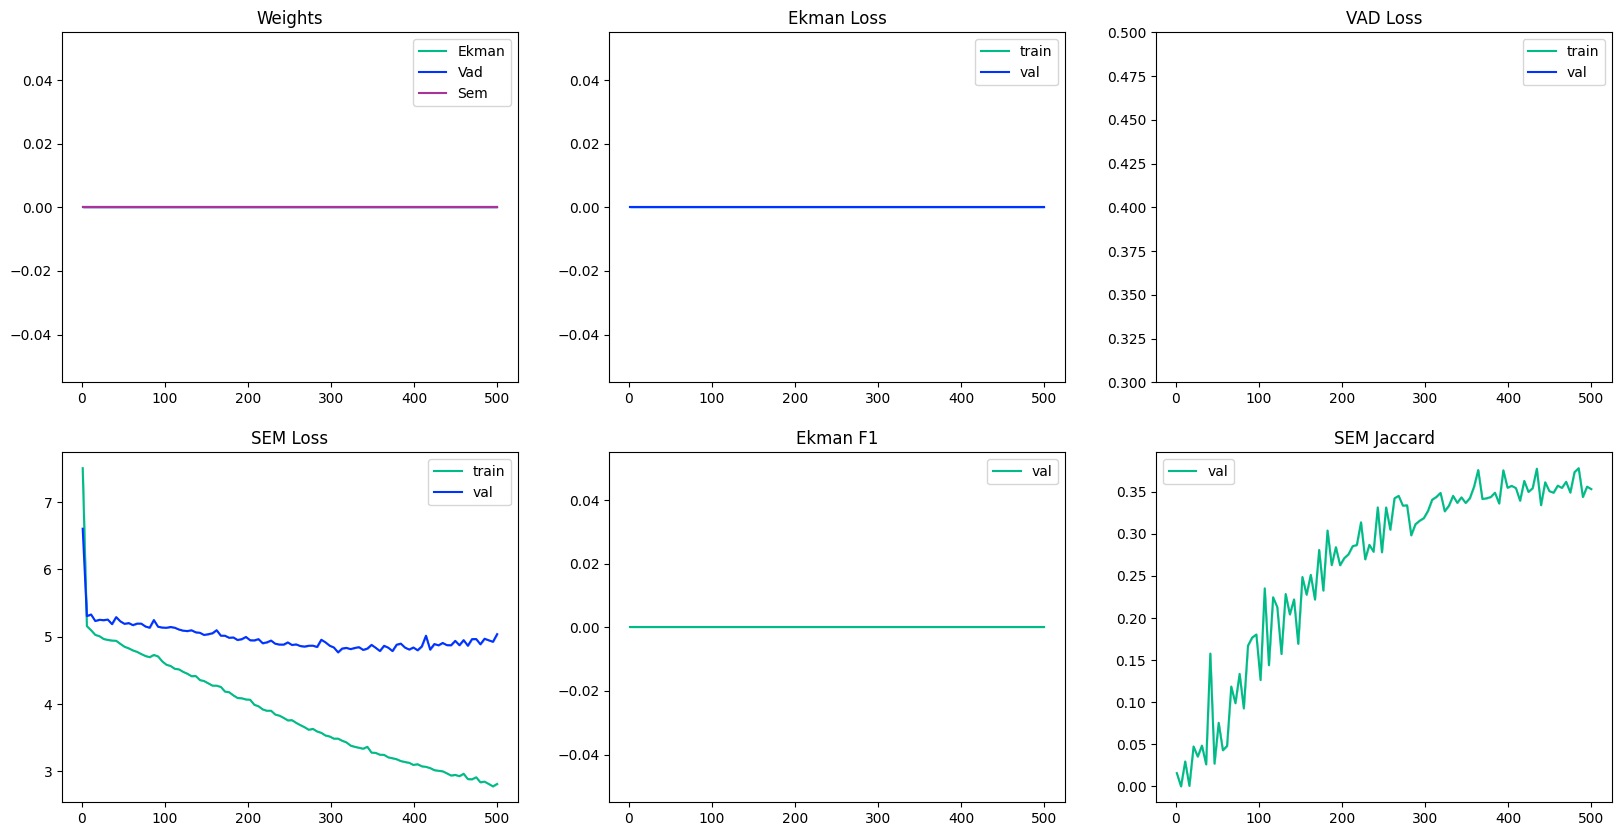

In [ ]:
summary_sem.plot()

In [ ]:
summary_sem.summary()

--------LOSSES--------
Ekman Loss: 1.609 +- 0.000
VAD Loss: 5.264 +- 0.000
sem Loss: 4.906 +- 0.000
Avg Loss: 11.779 +- 0.000
--------METRICS--------
Avg F1: 0.180 +- 0.000
Avg Jaccard: 0.330 +- 0.000
Avg V: 0.131 +- 0.000
Avg A: -0.065 +- 0.000
Avg D: 0.015 +- 0.000
Avg r: 0.027 +- 0.000
--------CONVERGENCE--------
Converged at: 307.000 +- 0.000


In [ ]:
for k, v in dataloaders.items():
  print(k)
  print(len(dataloaders[k]['train']))

## Combined

Use the following hyperparameters
```
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}
```

In [ ]:
%%capture experiment
summary_c = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'combined_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_c.add_history(exp.history)
  summary_c.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

(4, 100)


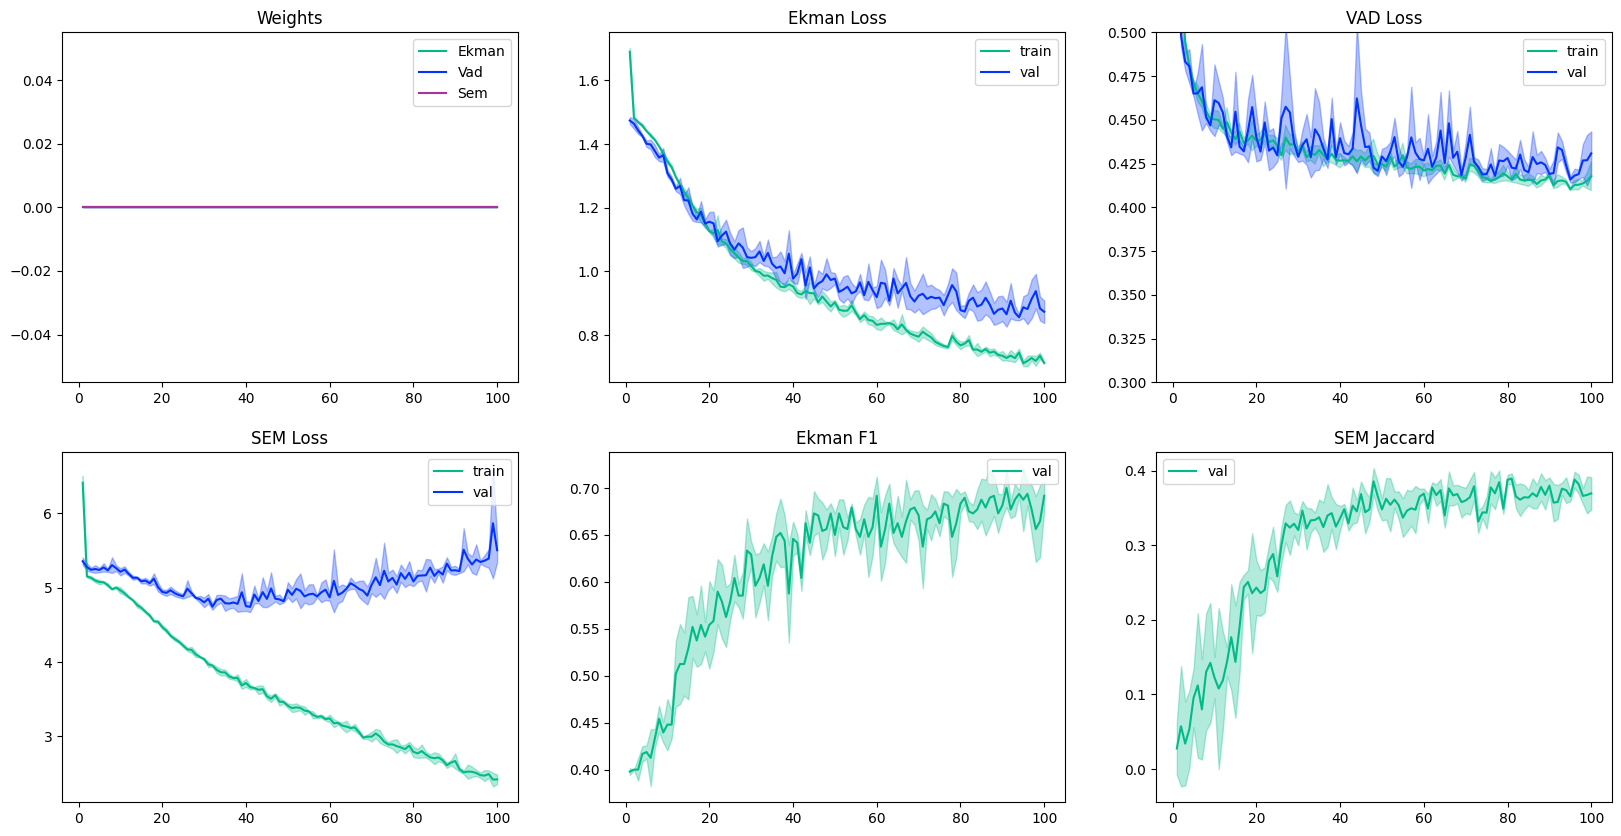

In [ ]:
summary_c.plot()

In [ ]:
summary_c.summary()

--------LOSSES--------
Ekman Loss: 0.980 +- 0.038
VAD Loss: 0.429 +- 0.006
sem Loss: 4.872 +- 0.049
Avg Loss: 6.282 +- 0.043
--------METRICS--------
Avg F1: 0.596 +- 0.020
Avg Jaccard: 0.335 +- 0.017
Avg V: 0.591 +- 0.008
Avg A: 0.375 +- 0.008
Avg D: 0.341 +- 0.011
Avg r: 0.436 +- 0.007
--------CONVERGENCE--------
Converged at: 41.250 +- 1.882


## Combined, small shared layer

In [ ]:
# %%capture experiment
summary_cs = Results_Summary()

log_with_wandb = False

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': [64, 32],
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(1):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'combined_small{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")
  
  net_big = MultiheadNetwork_large(h1=64, h2=32, dropout=0.8)
  # net_big = MultiheadNetwork(h_size=32, dropout=0.8)
  net_big.to(DEVICE)

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb, net=net_big)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_cs.add_history(exp.history)
  summary_cs.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

  0%|          | 0/140 [00:00<?, ?it/s]

recomputing L0...
Epoch 1: train ekman_loss = 1.767, vad loss = 4.697, sem loss = 7.447
Epoch 1: val ekman loss = 1.683, vad loss = 4.331, sem loss = 6.600
Epoch 1: f1 = 0.208, jaccard = 0.197, r = -0.009554731659591198, -0.037467386573553085, 0.009593646042048931


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 1
Epoch 2: train ekman_loss = 1.613, vad loss = 1.643, sem loss = 5.512
Epoch 2: val ekman loss = 1.577, vad loss = 0.576, sem loss = 5.321
Epoch 2: f1 = 0.367, jaccard = 0.001, r = 0.01348979864269495, 0.06864488124847412, 0.01535884477198124


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 2
Epoch 3: train ekman_loss = 1.499, vad loss = 0.553, sem loss = 5.117
Epoch 3: val ekman loss = 1.496, vad loss = 0.519, sem loss = 5.260
Epoch 3: f1 = 0.392, jaccard = 0.000, r = 0.0900522768497467, 0.03031640686094761, 0.09006913006305695


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 3
Epoch 4: train ekman_loss = 1.481, vad loss = 0.521, sem loss = 5.087
Epoch 4: val ekman loss = 1.457, vad loss = 0.513, sem loss = 5.262
Epoch 4: f1 = 0.400, jaccard = 0.000, r = 0.08256436884403229, 0.0726228654384613, 0.0809929221868515


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 4
Epoch 5: train ekman_loss = 1.468, vad loss = 0.509, sem loss = 5.064
Epoch 5: val ekman loss = 1.434, vad loss = 0.491, sem loss = 5.244
Epoch 5: f1 = 0.400, jaccard = 0.000, r = 0.13372819125652313, 0.09080883860588074, 0.11859414726495743


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 1.465, vad loss = 0.497, sem loss = 5.099
Epoch 6: val ekman loss = 1.429, vad loss = 0.507, sem loss = 5.238
Epoch 6: f1 = 0.408, jaccard = 0.006, r = 0.17886850237846375, 0.12061956524848938, 0.1067570224404335


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 6
Epoch 7: train ekman_loss = 1.451, vad loss = 0.488, sem loss = 5.050
Epoch 7: val ekman loss = 1.424, vad loss = 0.481, sem loss = 5.252
Epoch 7: f1 = 0.400, jaccard = 0.005, r = 0.18875986337661743, 0.12877948582172394, 0.1207377091050148


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 7
Epoch 8: train ekman_loss = 1.446, vad loss = 0.483, sem loss = 5.027
Epoch 8: val ekman loss = 1.419, vad loss = 0.474, sem loss = 5.235
Epoch 8: f1 = 0.400, jaccard = 0.005, r = 0.22451066970825195, 0.16571548581123352, 0.12881381809711456


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 8
Epoch 9: train ekman_loss = 1.434, vad loss = 0.477, sem loss = 5.032
Epoch 9: val ekman loss = 1.390, vad loss = 0.481, sem loss = 5.256
Epoch 9: f1 = 0.408, jaccard = 0.017, r = 0.25474944710731506, 0.13317622244358063, 0.1463494598865509


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 9
Epoch 10: train ekman_loss = 1.421, vad loss = 0.475, sem loss = 5.019
Epoch 10: val ekman loss = 1.391, vad loss = 0.466, sem loss = 5.239
Epoch 10: f1 = 0.433, jaccard = 0.001, r = 0.2697141468524933, 0.2073729932308197, 0.14574137330055237


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 10
Epoch 11: train ekman_loss = 1.418, vad loss = 0.468, sem loss = 5.034
Epoch 11: val ekman loss = 1.376, vad loss = 0.470, sem loss = 5.231
Epoch 11: f1 = 0.433, jaccard = 0.002, r = 0.2912386357784271, 0.20535582304000854, 0.14925576746463776


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 11
Epoch 12: train ekman_loss = 1.405, vad loss = 0.468, sem loss = 5.004
Epoch 12: val ekman loss = 1.363, vad loss = 0.464, sem loss = 5.227
Epoch 12: f1 = 0.433, jaccard = 0.002, r = 0.33027735352516174, 0.2331649214029312, 0.12382125109434128


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 1.395, vad loss = 0.466, sem loss = 4.982
Epoch 13: val ekman loss = 1.365, vad loss = 0.462, sem loss = 5.236
Epoch 13: f1 = 0.442, jaccard = 0.050, r = 0.3380512297153473, 0.24635794758796692, 0.1247783973813057


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 13
Epoch 14: train ekman_loss = 1.383, vad loss = 0.462, sem loss = 4.978
Epoch 14: val ekman loss = 1.343, vad loss = 0.460, sem loss = 5.196
Epoch 14: f1 = 0.433, jaccard = 0.001, r = 0.3731915056705475, 0.2475389689207077, 0.16716353595256805


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 14
Epoch 15: train ekman_loss = 1.367, vad loss = 0.460, sem loss = 4.954
Epoch 15: val ekman loss = 1.342, vad loss = 0.458, sem loss = 5.191
Epoch 15: f1 = 0.425, jaccard = 0.004, r = 0.39075976610183716, 0.27244094014167786, 0.14264073967933655


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 15
Epoch 16: train ekman_loss = 1.361, vad loss = 0.456, sem loss = 4.950
Epoch 16: val ekman loss = 1.329, vad loss = 0.454, sem loss = 5.194
Epoch 16: f1 = 0.458, jaccard = 0.148, r = 0.3907514214515686, 0.2930014729499817, 0.15562699735164642


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 16
Epoch 17: train ekman_loss = 1.345, vad loss = 0.454, sem loss = 4.946
Epoch 17: val ekman loss = 1.314, vad loss = 0.446, sem loss = 5.186
Epoch 17: f1 = 0.467, jaccard = 0.012, r = 0.4171094000339508, 0.307032972574234, 0.1625732183456421


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 1.338, vad loss = 0.446, sem loss = 4.910
Epoch 18: val ekman loss = 1.309, vad loss = 0.459, sem loss = 5.191
Epoch 18: f1 = 0.483, jaccard = 0.075, r = 0.430116206407547, 0.32531988620758057, 0.17050801217556


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 18
Epoch 19: train ekman_loss = 1.318, vad loss = 0.454, sem loss = 4.889
Epoch 19: val ekman loss = 1.289, vad loss = 0.446, sem loss = 5.167
Epoch 19: f1 = 0.500, jaccard = 0.076, r = 0.4354602098464966, 0.3273773491382599, 0.16641651093959808


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 19
Epoch 20: train ekman_loss = 1.313, vad loss = 0.448, sem loss = 4.860
Epoch 20: val ekman loss = 1.281, vad loss = 0.444, sem loss = 5.145
Epoch 20: f1 = 0.450, jaccard = 0.005, r = 0.43096694350242615, 0.32259389758110046, 0.1896767020225525


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 1.302, vad loss = 0.446, sem loss = 4.839
Epoch 21: val ekman loss = 1.292, vad loss = 0.441, sem loss = 5.181
Epoch 21: f1 = 0.517, jaccard = 0.068, r = 0.4412497282028198, 0.347006231546402, 0.1966656744480133


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 21
Epoch 22: train ekman_loss = 1.288, vad loss = 0.442, sem loss = 4.848
Epoch 22: val ekman loss = 1.287, vad loss = 0.443, sem loss = 5.122
Epoch 22: f1 = 0.467, jaccard = 0.117, r = 0.43409329652786255, 0.33586761355400085, 0.19164961576461792


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 22
Epoch 23: train ekman_loss = 1.288, vad loss = 0.448, sem loss = 4.840
Epoch 23: val ekman loss = 1.252, vad loss = 0.446, sem loss = 5.106
Epoch 23: f1 = 0.500, jaccard = 0.063, r = 0.44518718123435974, 0.3427942097187042, 0.18945592641830444


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 1.270, vad loss = 0.441, sem loss = 4.797
Epoch 24: val ekman loss = 1.258, vad loss = 0.450, sem loss = 5.127
Epoch 24: f1 = 0.542, jaccard = 0.070, r = 0.4516420364379883, 0.3483118414878845, 0.20409226417541504


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 1.265, vad loss = 0.444, sem loss = 4.774
Epoch 25: val ekman loss = 1.294, vad loss = 0.464, sem loss = 5.107
Epoch 25: f1 = 0.483, jaccard = 0.112, r = 0.45846667885780334, 0.3297036290168762, 0.1844828724861145


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 25
Epoch 26: train ekman_loss = 1.253, vad loss = 0.439, sem loss = 4.750
Epoch 26: val ekman loss = 1.229, vad loss = 0.439, sem loss = 5.084
Epoch 26: f1 = 0.483, jaccard = 0.113, r = 0.4672277569770813, 0.3483184278011322, 0.21044331789016724


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 26
Epoch 27: train ekman_loss = 1.241, vad loss = 0.442, sem loss = 4.752
Epoch 27: val ekman loss = 1.222, vad loss = 0.446, sem loss = 5.067
Epoch 27: f1 = 0.517, jaccard = 0.134, r = 0.46205899119377136, 0.34070467948913574, 0.20498140156269073


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 1.219, vad loss = 0.439, sem loss = 4.698
Epoch 28: val ekman loss = 1.213, vad loss = 0.445, sem loss = 5.081
Epoch 28: f1 = 0.592, jaccard = 0.120, r = 0.46510931849479675, 0.32863253355026245, 0.19018316268920898


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 28
Epoch 29: train ekman_loss = 1.214, vad loss = 0.439, sem loss = 4.681
Epoch 29: val ekman loss = 1.196, vad loss = 0.442, sem loss = 5.051
Epoch 29: f1 = 0.508, jaccard = 0.183, r = 0.47330406308174133, 0.36924126744270325, 0.2178916037082672


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 29
Epoch 30: train ekman_loss = 1.195, vad loss = 0.440, sem loss = 4.694
Epoch 30: val ekman loss = 1.207, vad loss = 0.443, sem loss = 5.038
Epoch 30: f1 = 0.542, jaccard = 0.147, r = 0.46915069222450256, 0.36034873127937317, 0.21153627336025238


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 30
Epoch 31: train ekman_loss = 1.183, vad loss = 0.434, sem loss = 4.648
Epoch 31: val ekman loss = 1.187, vad loss = 0.435, sem loss = 5.065
Epoch 31: f1 = 0.550, jaccard = 0.181, r = 0.4791014790534973, 0.3786563277244568, 0.20243743062019348


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 31
Epoch 32: train ekman_loss = 1.196, vad loss = 0.436, sem loss = 4.610
Epoch 32: val ekman loss = 1.200, vad loss = 0.435, sem loss = 5.045
Epoch 32: f1 = 0.550, jaccard = 0.231, r = 0.4855363368988037, 0.37448611855506897, 0.19787122309207916


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 32
Epoch 33: train ekman_loss = 1.172, vad loss = 0.443, sem loss = 4.596
Epoch 33: val ekman loss = 1.188, vad loss = 0.441, sem loss = 4.991
Epoch 33: f1 = 0.567, jaccard = 0.175, r = 0.47649234533309937, 0.37098708748817444, 0.1943116933107376


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 33
Epoch 34: train ekman_loss = 1.164, vad loss = 0.433, sem loss = 4.545
Epoch 34: val ekman loss = 1.177, vad loss = 0.436, sem loss = 5.000
Epoch 34: f1 = 0.550, jaccard = 0.185, r = 0.47844985127449036, 0.37738022208213806, 0.2061263620853424


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 1.154, vad loss = 0.434, sem loss = 4.565
Epoch 35: val ekman loss = 1.174, vad loss = 0.435, sem loss = 5.015
Epoch 35: f1 = 0.575, jaccard = 0.199, r = 0.48025912046432495, 0.3760905861854553, 0.19211851060390472


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 1.156, vad loss = 0.432, sem loss = 4.477
Epoch 36: val ekman loss = 1.128, vad loss = 0.435, sem loss = 5.244
Epoch 36: f1 = 0.600, jaccard = 0.254, r = 0.48682883381843567, 0.3755911886692047, 0.18233834207057953


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 36
Epoch 37: train ekman_loss = 1.148, vad loss = 0.431, sem loss = 4.473
Epoch 37: val ekman loss = 1.138, vad loss = 0.433, sem loss = 5.026
Epoch 37: f1 = 0.575, jaccard = 0.227, r = 0.4843149185180664, 0.3962274193763733, 0.21801114082336426


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 37
Epoch 38: train ekman_loss = 1.130, vad loss = 0.432, sem loss = 4.508
Epoch 38: val ekman loss = 1.162, vad loss = 0.432, sem loss = 4.950
Epoch 38: f1 = 0.592, jaccard = 0.204, r = 0.4855920970439911, 0.3968493640422821, 0.21860744059085846


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 1.123, vad loss = 0.429, sem loss = 4.456
Epoch 39: val ekman loss = 1.123, vad loss = 0.438, sem loss = 5.045
Epoch 39: f1 = 0.650, jaccard = 0.191, r = 0.4885438084602356, 0.38964933156967163, 0.22241094708442688


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 1.122, vad loss = 0.437, sem loss = 4.470
Epoch 40: val ekman loss = 1.159, vad loss = 0.444, sem loss = 4.950
Epoch 40: f1 = 0.525, jaccard = 0.228, r = 0.4917294383049011, 0.3952978253364563, 0.22274653613567352


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 1.101, vad loss = 0.430, sem loss = 4.406
Epoch 41: val ekman loss = 1.143, vad loss = 0.440, sem loss = 4.978
Epoch 41: f1 = 0.592, jaccard = 0.238, r = 0.48810088634490967, 0.38761982321739197, 0.1977631002664566


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 41
Epoch 42: train ekman_loss = 1.092, vad loss = 0.428, sem loss = 4.399
Epoch 42: val ekman loss = 1.104, vad loss = 0.431, sem loss = 4.910
Epoch 42: f1 = 0.583, jaccard = 0.226, r = 0.4918976128101349, 0.4030885100364685, 0.22652333974838257


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 1.097, vad loss = 0.429, sem loss = 4.356
Epoch 43: val ekman loss = 1.084, vad loss = 0.431, sem loss = 4.967
Epoch 43: f1 = 0.592, jaccard = 0.225, r = 0.49576571583747864, 0.3994203209877014, 0.22676995396614075


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 43
Epoch 44: train ekman_loss = 1.086, vad loss = 0.429, sem loss = 4.318
Epoch 44: val ekman loss = 1.103, vad loss = 0.433, sem loss = 4.885
Epoch 44: f1 = 0.592, jaccard = 0.265, r = 0.4992923140525818, 0.3994784653186798, 0.22071868181228638


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 1.071, vad loss = 0.427, sem loss = 4.310
Epoch 45: val ekman loss = 1.087, vad loss = 0.428, sem loss = 4.921
Epoch 45: f1 = 0.642, jaccard = 0.235, r = 0.5032025575637817, 0.4025067389011383, 0.23893676698207855


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 1.070, vad loss = 0.426, sem loss = 4.319
Epoch 46: val ekman loss = 1.118, vad loss = 0.445, sem loss = 4.895
Epoch 46: f1 = 0.592, jaccard = 0.259, r = 0.5011016130447388, 0.39745453000068665, 0.2412879765033722


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 46
Epoch 47: train ekman_loss = 1.064, vad loss = 0.428, sem loss = 4.270
Epoch 47: val ekman loss = 1.065, vad loss = 0.436, sem loss = 4.893
Epoch 47: f1 = 0.642, jaccard = 0.317, r = 0.504978597164154, 0.40108808875083923, 0.21586687862873077


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 47
Epoch 48: train ekman_loss = 1.058, vad loss = 0.427, sem loss = 4.264
Epoch 48: val ekman loss = 1.065, vad loss = 0.429, sem loss = 4.891
Epoch 48: f1 = 0.617, jaccard = 0.296, r = 0.5021848082542419, 0.39274972677230835, 0.24059037864208221


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 48
Epoch 49: train ekman_loss = 1.048, vad loss = 0.427, sem loss = 4.244
Epoch 49: val ekman loss = 1.055, vad loss = 0.444, sem loss = 4.871
Epoch 49: f1 = 0.625, jaccard = 0.312, r = 0.5056419372558594, 0.40433385968208313, 0.22659435868263245


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 49
Epoch 50: train ekman_loss = 1.048, vad loss = 0.430, sem loss = 4.227
Epoch 50: val ekman loss = 1.050, vad loss = 0.428, sem loss = 4.883
Epoch 50: f1 = 0.650, jaccard = 0.314, r = 0.5076532959938049, 0.4032413065433502, 0.2351001799106598


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 50
Epoch 51: train ekman_loss = 1.035, vad loss = 0.427, sem loss = 4.211
Epoch 51: val ekman loss = 1.037, vad loss = 0.427, sem loss = 4.840
Epoch 51: f1 = 0.617, jaccard = 0.310, r = 0.5073127150535583, 0.4047892987728119, 0.24029488861560822


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 52: train ekman_loss = 1.027, vad loss = 0.425, sem loss = 4.176
Epoch 52: val ekman loss = 1.060, vad loss = 0.463, sem loss = 4.849
Epoch 52: f1 = 0.617, jaccard = 0.272, r = 0.5095019340515137, 0.396694153547287, 0.23708105087280273


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 53: train ekman_loss = 1.030, vad loss = 0.426, sem loss = 4.144
Epoch 53: val ekman loss = 1.094, vad loss = 0.436, sem loss = 5.101
Epoch 53: f1 = 0.650, jaccard = 0.296, r = 0.5035682320594788, 0.3933604657649994, 0.23464801907539368


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 54: train ekman_loss = 1.023, vad loss = 0.427, sem loss = 4.161
Epoch 54: val ekman loss = 1.054, vad loss = 0.429, sem loss = 4.868
Epoch 54: f1 = 0.633, jaccard = 0.298, r = 0.5104904770851135, 0.4056607484817505, 0.21527954936027527


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 54
Epoch 55: train ekman_loss = 1.012, vad loss = 0.424, sem loss = 4.136
Epoch 55: val ekman loss = 1.027, vad loss = 0.434, sem loss = 4.835
Epoch 55: f1 = 0.658, jaccard = 0.296, r = 0.5015071630477905, 0.40891769528388977, 0.24381697177886963


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 56: train ekman_loss = 1.013, vad loss = 0.424, sem loss = 4.092
Epoch 56: val ekman loss = 1.021, vad loss = 0.425, sem loss = 4.850
Epoch 56: f1 = 0.658, jaccard = 0.325, r = 0.5075891017913818, 0.40861237049102783, 0.25202229619026184


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 57: train ekman_loss = 1.023, vad loss = 0.426, sem loss = 4.095
Epoch 57: val ekman loss = 1.026, vad loss = 0.444, sem loss = 4.882
Epoch 57: f1 = 0.658, jaccard = 0.315, r = 0.5069193840026855, 0.4117495119571686, 0.2504223883152008


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 58: train ekman_loss = 1.004, vad loss = 0.424, sem loss = 4.076
Epoch 58: val ekman loss = 1.063, vad loss = 0.444, sem loss = 4.820
Epoch 58: f1 = 0.617, jaccard = 0.335, r = 0.5100330114364624, 0.40880969166755676, 0.24249474704265594


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 59: train ekman_loss = 0.996, vad loss = 0.423, sem loss = 4.029
Epoch 59: val ekman loss = 1.076, vad loss = 0.426, sem loss = 4.819
Epoch 59: f1 = 0.592, jaccard = 0.312, r = 0.5072482824325562, 0.41534024477005005, 0.2559363543987274


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 59
Epoch 60: train ekman_loss = 1.000, vad loss = 0.425, sem loss = 4.035
Epoch 60: val ekman loss = 1.056, vad loss = 0.432, sem loss = 4.777
Epoch 60: f1 = 0.600, jaccard = 0.306, r = 0.5060617327690125, 0.4107692837715149, 0.2536221444606781


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 61: train ekman_loss = 0.996, vad loss = 0.422, sem loss = 3.983
Epoch 61: val ekman loss = 1.059, vad loss = 0.427, sem loss = 4.848
Epoch 61: f1 = 0.617, jaccard = 0.266, r = 0.509284257888794, 0.412566214799881, 0.24563996493816376


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 61
Epoch 62: train ekman_loss = 1.002, vad loss = 0.427, sem loss = 4.000
Epoch 62: val ekman loss = 1.002, vad loss = 0.430, sem loss = 4.793
Epoch 62: f1 = 0.633, jaccard = 0.328, r = 0.5092737674713135, 0.41649457812309265, 0.25337404012680054


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 63: train ekman_loss = 0.988, vad loss = 0.426, sem loss = 3.950
Epoch 63: val ekman loss = 1.003, vad loss = 0.443, sem loss = 4.843
Epoch 63: f1 = 0.692, jaccard = 0.326, r = 0.5116385817527771, 0.4132508337497711, 0.241463303565979


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 64: train ekman_loss = 0.983, vad loss = 0.424, sem loss = 3.972
Epoch 64: val ekman loss = 1.048, vad loss = 0.428, sem loss = 4.789
Epoch 64: f1 = 0.608, jaccard = 0.313, r = 0.5163870453834534, 0.4135293960571289, 0.2584814131259918


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 65: train ekman_loss = 0.980, vad loss = 0.427, sem loss = 4.001
Epoch 65: val ekman loss = 1.053, vad loss = 0.447, sem loss = 4.889
Epoch 65: f1 = 0.617, jaccard = 0.294, r = 0.51426100730896, 0.4162490963935852, 0.2590806484222412


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 66: train ekman_loss = 0.975, vad loss = 0.427, sem loss = 3.926
Epoch 66: val ekman loss = 1.002, vad loss = 0.429, sem loss = 4.808
Epoch 66: f1 = 0.675, jaccard = 0.327, r = 0.5186620354652405, 0.41499313712120056, 0.252343088388443


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 67: train ekman_loss = 0.970, vad loss = 0.424, sem loss = 3.930
Epoch 67: val ekman loss = 1.032, vad loss = 0.430, sem loss = 4.879
Epoch 67: f1 = 0.583, jaccard = 0.288, r = 0.5028104782104492, 0.41234415769577026, 0.2497013658285141


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 67
Epoch 68: train ekman_loss = 0.974, vad loss = 0.423, sem loss = 3.900
Epoch 68: val ekman loss = 1.030, vad loss = 0.435, sem loss = 4.734
Epoch 68: f1 = 0.625, jaccard = 0.336, r = 0.5170427560806274, 0.41510093212127686, 0.2529776394367218


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 69: train ekman_loss = 0.962, vad loss = 0.424, sem loss = 3.893
Epoch 69: val ekman loss = 1.031, vad loss = 0.427, sem loss = 4.761
Epoch 69: f1 = 0.625, jaccard = 0.344, r = 0.5147225856781006, 0.4141019284725189, 0.25414469838142395


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 70: train ekman_loss = 0.957, vad loss = 0.424, sem loss = 3.884
Epoch 70: val ekman loss = 1.024, vad loss = 0.426, sem loss = 4.857
Epoch 70: f1 = 0.633, jaccard = 0.312, r = 0.5145546793937683, 0.4157189130783081, 0.25778865814208984


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 70
Epoch 71: train ekman_loss = 0.958, vad loss = 0.425, sem loss = 3.870
Epoch 71: val ekman loss = 0.969, vad loss = 0.427, sem loss = 4.785
Epoch 71: f1 = 0.667, jaccard = 0.332, r = 0.5172775983810425, 0.41430240869522095, 0.2506145238876343


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 72: train ekman_loss = 0.951, vad loss = 0.423, sem loss = 3.814
Epoch 72: val ekman loss = 0.980, vad loss = 0.424, sem loss = 4.786
Epoch 72: f1 = 0.683, jaccard = 0.302, r = 0.5128662586212158, 0.4180220067501068, 0.25964832305908203


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 73: train ekman_loss = 0.956, vad loss = 0.420, sem loss = 3.806
Epoch 73: val ekman loss = 1.009, vad loss = 0.428, sem loss = 4.752
Epoch 73: f1 = 0.650, jaccard = 0.323, r = 0.5174945592880249, 0.4068099558353424, 0.26345837116241455


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 74: train ekman_loss = 0.951, vad loss = 0.420, sem loss = 3.782
Epoch 74: val ekman loss = 0.973, vad loss = 0.428, sem loss = 4.781
Epoch 74: f1 = 0.658, jaccard = 0.341, r = 0.5184582471847534, 0.41376054286956787, 0.25539445877075195


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 74
Epoch 75: train ekman_loss = 0.943, vad loss = 0.422, sem loss = 3.744
Epoch 75: val ekman loss = 1.014, vad loss = 0.428, sem loss = 4.703
Epoch 75: f1 = 0.633, jaccard = 0.327, r = 0.5189954042434692, 0.41539520025253296, 0.26075559854507446


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 75
Epoch 76: train ekman_loss = 0.944, vad loss = 0.423, sem loss = 3.797
Epoch 76: val ekman loss = 0.968, vad loss = 0.424, sem loss = 4.737
Epoch 76: f1 = 0.642, jaccard = 0.358, r = 0.5204294919967651, 0.4169367253780365, 0.2611524164676666


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 76
Epoch 77: train ekman_loss = 0.943, vad loss = 0.425, sem loss = 3.734
Epoch 77: val ekman loss = 0.985, vad loss = 0.428, sem loss = 4.698
Epoch 77: f1 = 0.700, jaccard = 0.337, r = 0.5195631980895996, 0.40184831619262695, 0.2483847737312317


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 78: train ekman_loss = 0.931, vad loss = 0.425, sem loss = 3.779
Epoch 78: val ekman loss = 0.968, vad loss = 0.434, sem loss = 4.739
Epoch 78: f1 = 0.658, jaccard = 0.332, r = 0.5207735300064087, 0.411553293466568, 0.2531103193759918


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 79: train ekman_loss = 0.932, vad loss = 0.420, sem loss = 3.700
Epoch 79: val ekman loss = 0.957, vad loss = 0.433, sem loss = 4.748
Epoch 79: f1 = 0.667, jaccard = 0.363, r = 0.5223050117492676, 0.4176292419433594, 0.25380557775497437


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 80: train ekman_loss = 0.920, vad loss = 0.421, sem loss = 3.713
Epoch 80: val ekman loss = 0.980, vad loss = 0.434, sem loss = 4.810
Epoch 80: f1 = 0.608, jaccard = 0.320, r = 0.5206170678138733, 0.4133186340332031, 0.23929648101329803


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 81: train ekman_loss = 0.927, vad loss = 0.421, sem loss = 3.723
Epoch 81: val ekman loss = 0.946, vad loss = 0.428, sem loss = 4.737
Epoch 81: f1 = 0.692, jaccard = 0.341, r = 0.5246602296829224, 0.40685927867889404, 0.24527963995933533


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 82: train ekman_loss = 0.918, vad loss = 0.420, sem loss = 3.660
Epoch 82: val ekman loss = 1.061, vad loss = 0.423, sem loss = 4.717
Epoch 82: f1 = 0.642, jaccard = 0.344, r = 0.5176437497138977, 0.4161625802516937, 0.27019941806793213


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 83: train ekman_loss = 0.928, vad loss = 0.423, sem loss = 3.677
Epoch 83: val ekman loss = 0.986, vad loss = 0.429, sem loss = 4.722
Epoch 83: f1 = 0.633, jaccard = 0.343, r = 0.5243674516677856, 0.40541204810142517, 0.2584742307662964


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 84: train ekman_loss = 0.935, vad loss = 0.423, sem loss = 3.660
Epoch 84: val ekman loss = 0.973, vad loss = 0.428, sem loss = 4.810
Epoch 84: f1 = 0.658, jaccard = 0.334, r = 0.5271266102790833, 0.40403056144714355, 0.2642153203487396


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 85: train ekman_loss = 0.916, vad loss = 0.420, sem loss = 3.642
Epoch 85: val ekman loss = 0.966, vad loss = 0.429, sem loss = 4.816
Epoch 85: f1 = 0.642, jaccard = 0.328, r = 0.524909257888794, 0.42239052057266235, 0.25790947675704956


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 85
Epoch 86: train ekman_loss = 0.908, vad loss = 0.419, sem loss = 3.606
Epoch 86: val ekman loss = 0.960, vad loss = 0.432, sem loss = 4.704
Epoch 86: f1 = 0.667, jaccard = 0.350, r = 0.5209746956825256, 0.4142160713672638, 0.25771939754486084


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 87: train ekman_loss = 0.920, vad loss = 0.420, sem loss = 3.633
Epoch 87: val ekman loss = 0.968, vad loss = 0.422, sem loss = 4.841
Epoch 87: f1 = 0.625, jaccard = 0.332, r = 0.5289620757102966, 0.41871577501296997, 0.27042269706726074


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 88: train ekman_loss = 0.909, vad loss = 0.423, sem loss = 3.630
Epoch 88: val ekman loss = 0.942, vad loss = 0.438, sem loss = 4.737
Epoch 88: f1 = 0.667, jaccard = 0.361, r = 0.5047228932380676, 0.41172072291374207, 0.261969655752182


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 89: train ekman_loss = 0.913, vad loss = 0.419, sem loss = 3.569
Epoch 89: val ekman loss = 0.988, vad loss = 0.425, sem loss = 4.707
Epoch 89: f1 = 0.667, jaccard = 0.338, r = 0.5259095430374146, 0.42146894335746765, 0.25906941294670105


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 90: train ekman_loss = 0.904, vad loss = 0.419, sem loss = 3.566
Epoch 90: val ekman loss = 0.980, vad loss = 0.422, sem loss = 4.697
Epoch 90: f1 = 0.650, jaccard = 0.354, r = 0.5262262225151062, 0.42127951979637146, 0.2660320997238159


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 91: train ekman_loss = 0.916, vad loss = 0.421, sem loss = 3.594
Epoch 91: val ekman loss = 0.964, vad loss = 0.424, sem loss = 4.780
Epoch 91: f1 = 0.667, jaccard = 0.342, r = 0.5204867124557495, 0.40996047854423523, 0.2660779058933258


  0%|          | 0/140 [00:00<?, ?it/s]

updating best net at epoch 91
Epoch 92: train ekman_loss = 0.913, vad loss = 0.420, sem loss = 3.571
Epoch 92: val ekman loss = 0.961, vad loss = 0.423, sem loss = 4.675
Epoch 92: f1 = 0.675, jaccard = 0.348, r = 0.5267955660820007, 0.4176414906978607, 0.2713412642478943


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 93: train ekman_loss = 0.892, vad loss = 0.418, sem loss = 3.515
Epoch 93: val ekman loss = 0.976, vad loss = 0.426, sem loss = 4.710
Epoch 93: f1 = 0.642, jaccard = 0.360, r = 0.5245780944824219, 0.4130779504776001, 0.26834049820899963


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 94: train ekman_loss = 0.895, vad loss = 0.419, sem loss = 3.501
Epoch 94: val ekman loss = 0.936, vad loss = 0.422, sem loss = 4.814
Epoch 94: f1 = 0.692, jaccard = 0.335, r = 0.5353630185127258, 0.42325326800346375, 0.2644641697406769


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 95: train ekman_loss = 0.887, vad loss = 0.419, sem loss = 3.509
Epoch 95: val ekman loss = 0.984, vad loss = 0.422, sem loss = 4.747
Epoch 95: f1 = 0.642, jaccard = 0.349, r = 0.5353032946586609, 0.41506266593933105, 0.2657982110977173


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 96: train ekman_loss = 0.888, vad loss = 0.418, sem loss = 3.471
Epoch 96: val ekman loss = 0.921, vad loss = 0.424, sem loss = 4.741
Epoch 96: f1 = 0.683, jaccard = 0.372, r = 0.5312846899032593, 0.4108394980430603, 0.25617432594299316


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 97: train ekman_loss = 0.877, vad loss = 0.419, sem loss = 3.458
Epoch 97: val ekman loss = 0.945, vad loss = 0.431, sem loss = 4.770
Epoch 97: f1 = 0.667, jaccard = 0.348, r = 0.5269683003425598, 0.3917064964771271, 0.25170692801475525


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 98: train ekman_loss = 0.892, vad loss = 0.421, sem loss = 3.498
Epoch 98: val ekman loss = 0.991, vad loss = 0.426, sem loss = 4.711
Epoch 98: f1 = 0.642, jaccard = 0.334, r = 0.5310966968536377, 0.4059506058692932, 0.26937031745910645


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 99: train ekman_loss = 0.877, vad loss = 0.424, sem loss = 3.457
Epoch 99: val ekman loss = 0.922, vad loss = 0.424, sem loss = 4.725
Epoch 99: f1 = 0.692, jaccard = 0.360, r = 0.5304014086723328, 0.41837233304977417, 0.26686808466911316


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 100: train ekman_loss = 0.869, vad loss = 0.417, sem loss = 3.456
Epoch 100: val ekman loss = 0.956, vad loss = 0.420, sem loss = 4.792
Epoch 100: f1 = 0.675, jaccard = 0.336, r = 0.5416219830513, 0.42702266573905945, 0.264989972114563
TEST SET (combined)
Total Loss = 6.306
Ekman Loss = 0.930
VAD Loss = 0.422
sem Loss = 4.954
F1 = 0.6311
r = V: 0.5977, A: 0.3674, D: 0.3220
Jaccard = 0.3205
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 6.167
Ekman Loss = 0.939
VAD Loss = 0.422
sem Loss = 4.806
F1 = 0.5984
r = V: 0.5928, A: 0.3708, D: 0.3193
Jaccard = 0.3381


(1, 100)


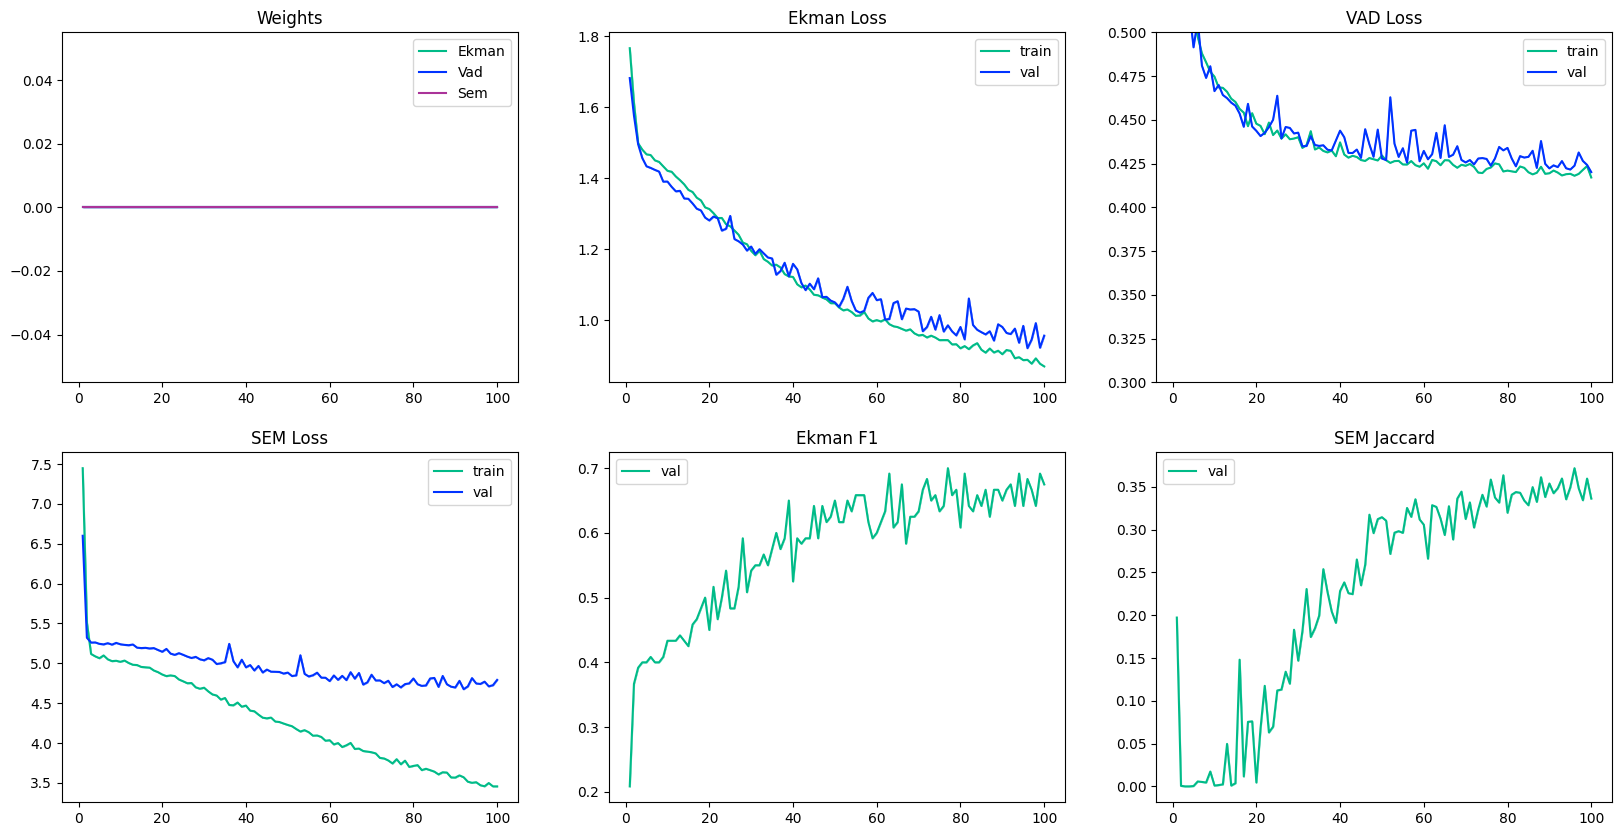

In [ ]:
summary_cs.plot()

In [ ]:
summary_cs.summary()

--------LOSSES--------
Ekman Loss: 0.971 +- 0.000
VAD Loss: 0.432 +- 0.000
sem Loss: 4.724 +- 0.000
Avg Loss: 6.126 +- 0.000
--------METRICS--------
Avg F1: 0.590 +- 0.000
Avg Jaccard: 0.361 +- 0.000
Avg V: 0.569 +- 0.000
Avg A: 0.328 +- 0.000
Avg D: 0.313 +- 0.000
Avg r: 0.403 +- 0.000
--------CONVERGENCE--------
Converged at: 60.000 +- 0.000


## Ekman + SEM

In [ ]:
%%capture experiment
summary_es = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "ekman-sem",
    "val_dataset": "ekman-sem",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'ekman-sem_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_es.add_history(exp.history)
  summary_es.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

# close_wandb()

In [ ]:
summary_es.plot()

In [ ]:
summary_es.summary()

--------LOSSES--------
Ekman Loss: 0.837 +- 0.008
VAD Loss: 5.264 +- 0.000
sem Loss: 4.047 +- 0.026
Avg Loss: 10.148 +- 0.031
--------METRICS--------
Avg F1: 0.691 +- 0.014
Avg Jaccard: 0.418 +- 0.008
Avg V: -0.000 +- 0.000
Avg A: 0.000 +- 0.000
Avg D: -0.000 +- 0.000
Avg r: -0.000 +- 0.000
--------CONVERGENCE--------
Converged at: 94.750 +- 4.511


## Ekman + VAD

In [ ]:
%%capture experiment
summary_ev = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "ekman-vad",
    "val_dataset": "ekman-vad",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'ekman-vad_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_ev.add_history(exp.history)
  summary_ev.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

In [ ]:
summary_ev.plot()

In [ ]:
summary_ev.summary()

--------LOSSES--------
Ekman Loss: 0.907 +- 0.025
VAD Loss: 0.418 +- 0.006
sem Loss: 7.625 +- 0.000
Avg Loss: 8.949 +- 0.024
--------METRICS--------
Avg F1: 0.664 +- 0.015
Avg Jaccard: 0.000 +- 0.000
Avg V: 0.623 +- 0.009
Avg A: 0.441 +- 0.006
Avg D: 0.378 +- 0.002
Avg r: 0.481 +- 0.003
--------CONVERGENCE--------
Converged at: 86.000 +- 5.139


## VAD + SEM

In [ ]:
%%capture experiment
summary_vs = Results_Summary()

log_with_wandb = False

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "vad-sem",
    "val_dataset": "vad-sem",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'vad-sem_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_vs.add_history(exp.history)
  summary_vs.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

# close_wandb()

In [ ]:
summary_vs.plot()

In [ ]:
summary_vs.summary()

--------LOSSES--------
Ekman Loss: 1.609 +- 0.000
VAD Loss: 0.411 +- 0.007
sem Loss: 3.990 +- 0.012
Avg Loss: 6.010 +- 0.010
--------METRICS--------
Avg F1: 0.205 +- 0.000
Avg Jaccard: 0.430 +- 0.009
Avg V: 0.641 +- 0.012
Avg A: 0.442 +- 0.008
Avg D: 0.380 +- 0.008
Avg r: 0.488 +- 0.006
--------CONVERGENCE--------
Converged at: 89.250 +- 1.750


## Combined, with GradNorm

In [ ]:
%%capture experiment
summary_gn = Results_Summary()

log_with_wandb = True

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2.0,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(4):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'combined_gn_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_gn.add_history(exp.history)
  summary_gn.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

(1, 100)


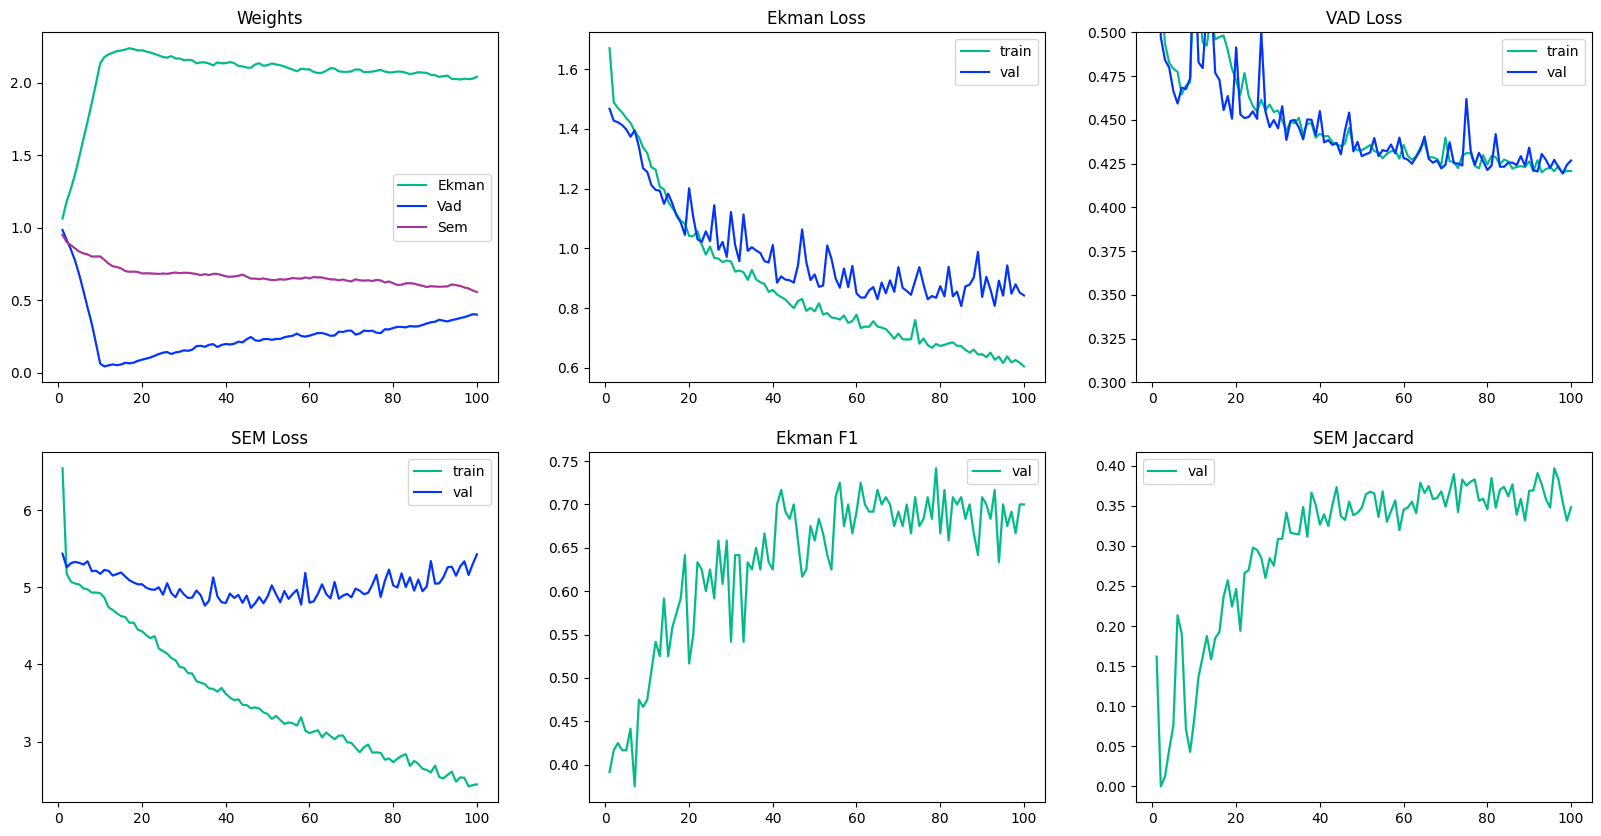

In [ ]:
summary_gn.plot()

In [ ]:
summary_gn.summary()

--------LOSSES--------
Ekman Loss: 0.957 +- 0.000
VAD Loss: 0.436 +- 0.000
sem Loss: 4.597 +- 0.000
Avg Loss: 5.991 +- 0.000
--------METRICS--------
Avg F1: 0.623 +- 0.000
Avg Jaccard: 0.371 +- 0.000
Avg V: 0.549 +- 0.000
Avg A: 0.299 +- 0.000
Avg D: 0.260 +- 0.000
Avg r: 0.369 +- 0.000
--------CONVERGENCE--------
Converged at: 59.000 +- 0.000


## Combined, gradNorm=0.5

In [ ]:
# %%capture experiment
summary_gn2 = Results_Summary()

log_with_wandb = False

config = {
    "Sem_percent": percentage_sem, 
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 1,
    "dropout": 0.8,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

for i in range(1):
  if log_with_wandb:
    wandb.init(project="MultiEmo3", name=f'combined_gn_{i+1}', config=config)
    # settings=wandb.Settings(start_method="thread")

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, r, jaccard = exp.evaluate()
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 
                  'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard, 'r': r, 
                  'best_e': exp.best_epoch}
  
  summary_gn2.add_history(exp.history)
  summary_gn2.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

(4, 100)


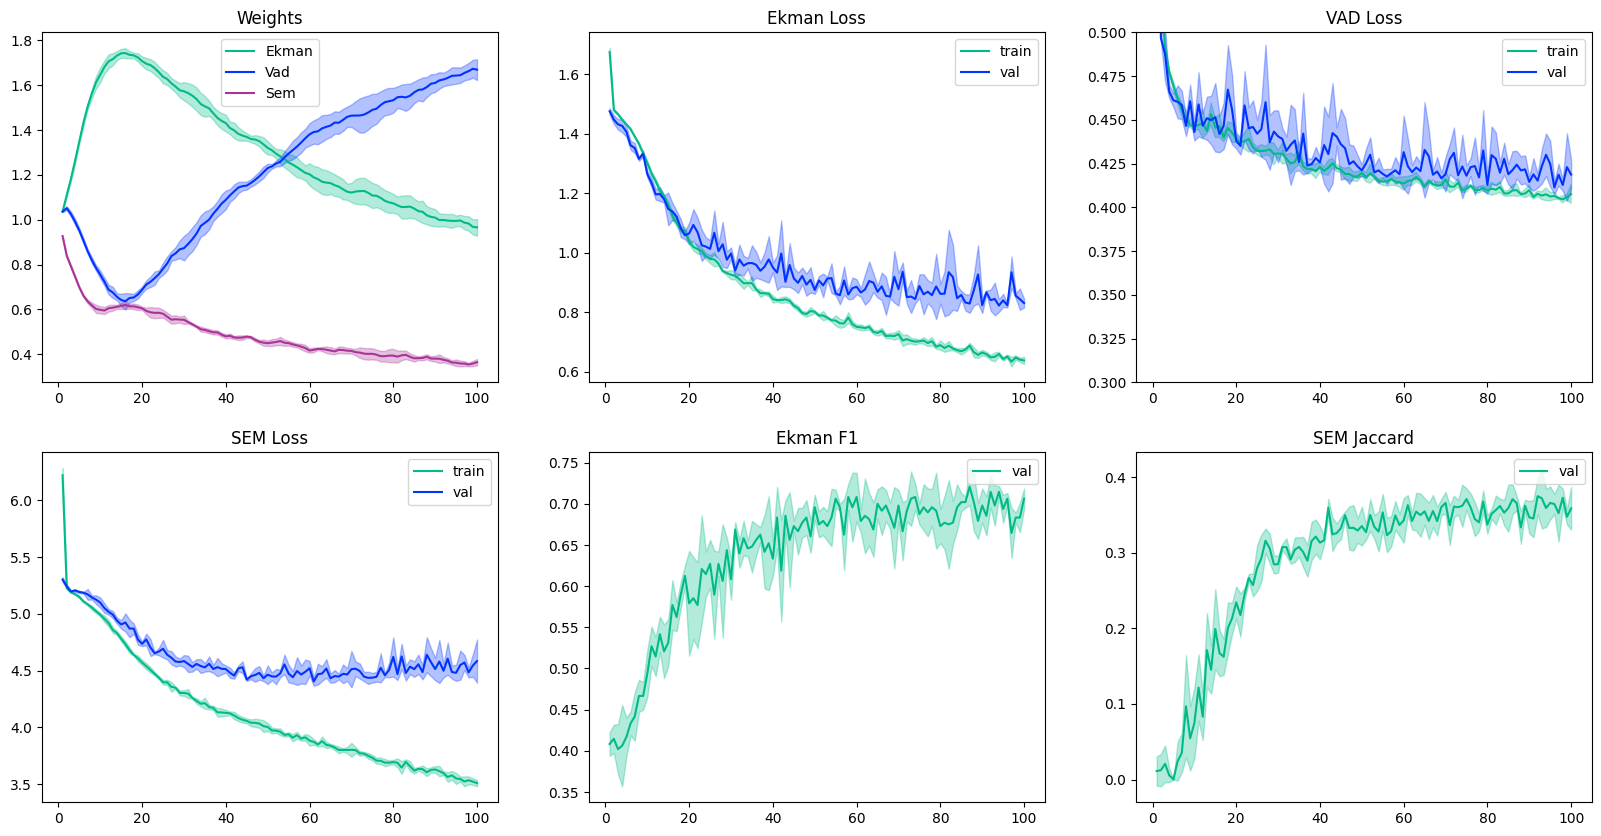

In [ ]:
summary_gn2.plot()

In [ ]:
summary_gn2.summary()

--------LOSSES--------
Ekman Loss: 0.866 +- 0.020
VAD Loss: 0.420 +- 0.002
sem Loss: 4.498 +- 0.011
Avg Loss: 5.784 +- 0.010
--------METRICS--------
Avg F1: 0.662 +- 0.015
Avg Jaccard: 0.365 +- 0.008
Avg V: 0.612 +- 0.003
Avg A: 0.424 +- 0.008
Avg D: 0.364 +- 0.009
Avg r: 0.467 +- 0.004
--------CONVERGENCE--------
Converged at: 74.250 +- 9.785


# Archived Experiments

## Test larger hidden layer size

In [ ]:
class MultiheadNetwork_large(nn.Module):
  def __init__(self, h1=256, h2=128, dropout=0.5):
    super().__init__()
    
    self.shared_base_0 = nn.Linear(768, h1)
    self.shared_base = nn.Linear(h1, h2)
    self.ekman_predictor = nn.Linear(h2, OUT_DIMS['ekman'])
    self.vad_predictor = nn.Linear(h2, OUT_DIMS['vad'])
    self.sem_predictor = nn.Linear(h2, OUT_DIMS['sem'])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base_0(X))
    X = self.dropout(X)
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    sem_filter = task[:, 2].unsqueeze(-1)
    y_sem = sem_filter * self.sem_predictor(X)
    y_sem = self.sigmoid(y_sem)

    y = torch.concat((y_ekman, y_vad, y_sem), dim=1)

    return y

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

net_big = MultiheadNetwork_large(dropout=0.5)
net_big.to(DEVICE)

exp_big = TrainingManager(dataloaders, config, wandb=False, net=net_big)

In [ ]:
exp_big.evaluate()

TEST SET (combined)
Total Loss = 5.095
Ekman Loss = 0.932
VAD Loss = 0.100
sem Loss = 4.063
F1 = 0.6475
MSE = 0.0100
Jaccard = 0.4088


In [ ]:
exp_big.train(epochs=50)

In [ ]:
exp_big.plot_history()

## large net, more decay

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-4,
    'lr': 5e-4,
}

net_big2 = MultiheadNetwork_large(dropout=0.5)
net_big2.to(DEVICE)

exp_big2 = TrainingManager(dataloaders, config, wandb=False, net=net_big2)

In [ ]:
exp_big2.evaluate()

TEST SET (combined)
Total Loss = 4.715
Ekman Loss = 0.527
VAD Loss = 0.097
sem Loss = 4.091
F1 = 0.8318
MSE = 0.0094
Jaccard = 0.4343


In [ ]:
exp_big2.train(epochs=100)

In [ ]:
exp_big2.plot_history()

## Large net, decay = 1e-3

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 5e-4,
}

net_big3 = MultiheadNetwork_large(h1=256, h2=128, dropout=0.5)
net_big3.to(DEVICE)

exp_big3 = TrainingManager(dataloaders, config, wandb=False, net=net_big3)

In [ ]:
exp_big3.evaluate()

TEST SET (combined)
Total Loss = 4.570
Ekman Loss = 0.505
VAD Loss = 0.094
sem Loss = 3.971
F1 = 0.8229
MSE = 0.0087
Jaccard = 0.4263


In [ ]:
exp_big3.train(epochs=100)

In [ ]:
exp_big3.plot_history()

## Large net, less params, 1e-3 decay

In [ ]:
config = {
    "dataset": "vad",
    "val_dataset": "vad",
    "gradNorm": False,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 3e-4,
}

net_big4 = MultiheadNetwork_large(h1=64, h2=32, dropout=0.8)
# net_big4 = MultiheadNetwork(h_size=64, dropout=0.8)
net_big4.to(DEVICE)

exp_big4 = TrainingManager(dataloaders, config, wandb=False, net=net_big4)

In [ ]:
exp_big4._evaluate(dataloaders['combined']['test'])

(tensor([1.6094, 0.4170, 7.6246]),
 tensor(0.3197),
 [tensor(0.6111), tensor(0.3997), tensor(0.3370)],
 tensor(0.1326))

In [ ]:
exp_big4.train(epochs=20)

In [ ]:
exp_big4.plot_history()

In [ ]:
exp_big4.plot_history()

## More dropout, large net

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 5e-4,
}

net_big5 = MultiheadNetwork_large(h1=256, h2=128, dropout=0.8)
net_big5.to(DEVICE)

exp_big5 = TrainingManager(dataloaders, config, wandb=False, net=net_big5)

In [ ]:
exp_big5.evaluate()

TEST SET (combined)
Total Loss = 10.354
Ekman Loss = 1.599
VAD Loss = 1.070
sem Loss = 7.686
F1 = 0.2787
MSE = 1.1454
Jaccard = 0.2178


In [ ]:
exp_big5.train(epochs=100)

In [ ]:
exp_big5.plot_history()

In [ ]:
exp_big5.evaluate()

TEST SET (combined)
Total Loss = 5.043
Ekman Loss = 0.899
VAD Loss = 0.097
sem Loss = 4.047
F1 = 0.6885
MSE = 0.0094
Jaccard = 0.3895


## 0.8 Dropout with no GN

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 2.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-3,
    'lr': 5e-4,
}

net_big6 = MultiheadNetwork_large(h1=256, h2=128, dropout=0.8)
net_big6.to(DEVICE)

exp_big6 = TrainingManager(dataloaders, config, wandb=False, net=net_big6)

In [ ]:
exp_big6.evaluate()

TEST SET (combined)
Total Loss = 5.128
Ekman Loss = 0.988
VAD Loss = 0.096
sem Loss = 4.043
F1 = 0.6721
MSE = 0.0093
Jaccard = 0.4284
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.998
Ekman Loss = 0.922
VAD Loss = 0.098
sem Loss = 3.978
F1 = 0.6721
MSE = 0.0097
Jaccard = 0.4233


In [ ]:
exp_big6.train(epochs=100)

In [ ]:
exp_big6.plot_history()

In [ ]:
exp_big6.evaluate()

TEST SET (combined)
Total Loss = 5.128
Ekman Loss = 0.988
VAD Loss = 0.096
sem Loss = 4.043
F1 = 0.6721
MSE = 0.0093
Jaccard = 0.4284
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.998
Ekman Loss = 0.922
VAD Loss = 0.098
sem Loss = 3.978
F1 = 0.6721
MSE = 0.0097
Jaccard = 0.4233
